In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

import warnings
warnings.filterwarnings('ignore')

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Utility Function

### Function to create a dataframe of percentage of NaN values for each column of the dataframe

In [2]:
def nan_df_create(data):

    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})

    #sorting the dataframe by decreasing order of percentage of NaN values
    df.sort_values(by = 'percent', ascending = False, inplace = True)

    return df

### Function to plot Bar Plots of NaN percentages for each Column with missing values

In [3]:
def plot_nan_percent(df_nan, title_name, tight_layout = True, figsize = (20,8), grid = False, rotation = 90):

    #checking if there is any column with NaNs or not.
    if df_nan.percent.sum() != 0:
        print(f"Number of columns having NaN values: {df_nan[df_nan['percent'] != 0].shape[0]} columns")

        #plotting the Bar-Plot for NaN percentages (only for columns with Non-Zero percentage of NaN values)
        plt.figure(figsize = figsize, tight_layout = tight_layout)
        sns.barplot(x= 'column', y = 'percent', data = df_nan[df_nan['percent'] > 0])
        plt.xticks(rotation = rotation)
        plt.xlabel('Column Name')
        plt.ylabel('Percentage of NaN values')
        plt.title(f'Percentage of NaN values in {title_name}')
        if grid:
            plt.grid()
        plt.show()
    else:
        print(f"The dataframe {title_name} does not contain any NaN values.")

### Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.

In [4]:
class correlation_matrix:

    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True,
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):

        '''Function to initialize the class members.'''


        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap

    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap

        '''

        print('-' * 100)
        #building the correlation dataframe
        numerical_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis=1).select_dtypes(include=np.number)
        self.corr_data = numerical_data.corr()
        if self.mask_upper:
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)

    def target_top_corr(self, target_top_columns = 10):
        '''
        Function to return the Top Correlated features with the Target
        
        '''

        phik_target_arr = np.zeros(self.corr_data.shape[1])
        #calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0,1]
        #getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns, 'Phik-Correlation' : phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(by = 'Phik-Correlation', ascending = False)

        return top_corr_target_df.iloc[:target_top_columns]

### Function to Phi_k matrix for categorical features

In [5]:
def plot_phik_matrix(data, categorical_columns, figsize = (20,20), mask_upper = True, tight_layout = True, linewidth = 0.1, fontsize = 10, cmap = 'Blues', show_target_top_corr = True, target_top_columns = 10):

    '''
    Function to Phi_k matrix for categorical features

    '''

    #first fetching only the categorical features
    data_for_phik = data[categorical_columns].astype('object')
    phik_matrix = data_for_phik.phik_matrix()

    print('-'*100)

    if mask_upper:
        mask_array = np.ones(phik_matrix.shape)
        mask_array = np.triu(mask_array)
    else:
        mask_array = np.zeros(phik_matrix.shape)

    plt.figure(figsize = figsize, tight_layout = tight_layout)
    sns.heatmap(phik_matrix, annot = False, mask = mask_array, linewidth = linewidth, cmap = cmap)
    plt.xticks(rotation = 90, fontsize = fontsize)
    plt.yticks(rotation = 0, fontsize = fontsize)
    plt.title("Phi-K Correlation Heatmap for Categorical Features")
    plt.show()
    print("-"*100)

    if show_target_top_corr:
        #Seeing the top columns with highest correlation with the target variable in application_train
        print("Categories with highest values of Phi-K Correlation value with Target Variable are:")
        phik_df = pd.DataFrame({'Column Name' : phik_matrix.TARGET.index[1:], 'Phik-Correlation' : phik_matrix.TARGET.values[1:]})
        phik_df = phik_df.sort_values(by = 'Phik-Correlation', ascending = False)
        display(phik_df.head(target_top_columns))
        print("-"*100)

### Function to plot Categorical Variables Bar Plots

In [6]:
def plot_categorical_variables_bar(data, column_name, figsize=(18,6), percentage_display=True, plot_defaulter=True, rotation=0, horizontal_adjust=0, fontsize_percent='xx-small'):
    '''
    Function to plot Categorical Variables Bar Plots.
    Limits the number of categories displayed to 10 if there are more than 10 unique categories.
    '''

    # Retrieve and limit the number of categories to plot
    unique_categories = data[column_name].unique()
    print(f"Total Number of unique categories of {column_name} = {len(unique_categories)}")

    plt.figure(figsize=figsize, tight_layout=False)
    sns.set(style='whitegrid', font_scale=1.2)

    # Plotting overall distribution of category, limited to the first 10 if more than 10
    plt.subplot(1, 2, 1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending=False)[:10]
    ax = sns.barplot(x=data_to_plot.index, y=data_to_plot, palette='Set1')

    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints, '{:1.2f}%'.format(p.get_height() * 100 / total_datapoints), fontsize=fontsize_percent)

    plt.xlabel(column_name, labelpad=10)
    plt.title(f'Distribution of {column_name}', pad=20)
    plt.xticks(rotation=rotation)
    plt.ylabel('Counts')

    # Plotting distribution of category for Defaulters, limited to the first 10 if more than 10
    if plot_defaulter:
        plt.subplot(1, 2, 2)
        percentage_defaulter_per_category = (data[column_name][data['TARGET'] == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending=False)[:10]
        sns.barplot(x=percentage_defaulter_per_category.index, y=percentage_defaulter_per_category, palette='Set2')
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad=10)
        plt.xticks(rotation=rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad=20)
    plt.show()

### Function to plot categorical variables Pie Plots

In [7]:
def plot_categorical_variables_bar(data, column_name, figsize=(18,6), percentage_display=True, plot_defaulter=True, rotation=0, horizontal_adjust=0, fontsize_percent='small'):
    '''
    Function to plot Categorical Variables Bar Plots.
    Limits the number of categories displayed to 10 if there are more than 10 unique categories.
    Displays percentage in the middle of the bars with improved readability.
    '''

    # Retrieve and limit the number of categories to plot
    unique_categories = data[column_name].unique()
    print(f"Total Number of unique categories of {column_name} = {len(unique_categories)}")

    plt.figure(figsize=figsize, tight_layout=False)
    sns.set(style='whitegrid', font_scale=1.2)

    # Plotting overall distribution of category, limited to the first 10 if more than 10
    plt.subplot(1, 2, 1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending=False)[:10]
    ax = sns.barplot(x=data_to_plot.index, y=data_to_plot, palette='Set1')

    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            # Calculate the percentage for each bar
            percentage = p.get_height() * 100 / total_datapoints
            # Get the position to center the percentage text on the bar
            x_position = p.get_x() + p.get_width() / 2
            y_position = p.get_height() / 2  # Positioning text in the middle of the bar
            # Adjust the text to make it more readable
            ax.text(x_position, y_position, f'{percentage:1.2f}%', ha='center', va='center', fontsize=fontsize_percent, color='black', fontweight='bold')

    plt.xlabel(column_name, labelpad=10)
    plt.title(f'Distribution of {column_name}', pad=20)
    plt.xticks(rotation=rotation)
    plt.ylabel('Counts')

    if plot_defaulter:
        plt.subplot(1, 2, 2)
        percentage_defaulter_per_category = (data[column_name][data['TARGET'] == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending=False)[:10]
        sns.barplot(x=percentage_defaulter_per_category.index, y=percentage_defaulter_per_category, palette='Set2')
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad=10)
        plt.xticks(rotation=rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad=20)
        
        if percentage_display:
            for p in plt.gca().patches:
                percentage = p.get_height()
                x_position = p.get_x() + p.get_width() / 2
                y_position = p.get_height() / 2
                # Adjust the text to make it more readable
                plt.text(x_position, y_position, f'{percentage:1.2f}%', ha='center', va='center', fontsize=fontsize_percent, color='black', fontweight='bold')

    plt.show()

#### Function to print the basic stats such as unique categories and their counts for categorical variables

In [8]:
def print_unique_categories(data, column_name, show_counts = False):

    '''
    Function to print the basic stats such as unique categories and their counts for categorical variables

    '''

    print('-'*100)
    print(f"The unique categories of '{column_name}' are:\n{data[column_name].unique()}")
    print('-'*100)

    if show_counts:
        print(f"Counts of each category are:\n{data[column_name].value_counts()}")
        print('-'*100)

### Function to plot CDF of a continuour variable

In [9]:
def plot_cdf(data, column_name, log_scale = False, figsize = (12,8)):

    '''
    Function to plot CDF of a continuour variable

    '''


    percentile_values = data[[column_name]].dropna().sort_values(by = column_name)
    percentile_values['Percentile'] = [ele / (len(percentile_values) - 1) for ele in range(len(percentile_values))]

    plt.figure(figsize = figsize)
    if log_scale:
        plt.xscale('log')
        plt.xlabel(column_name + ' - (log-scale)')
    else:
        plt.xlabel(column_name)
    plt.plot(percentile_values[column_name], percentile_values['Percentile'], color = 'red')
    plt.ylabel('Probability')
    plt.title('CDF of {}'.format(column_name))
    plt.show()

### Function to print percentile values for given column


In [10]:
def print_percentiles(data, column_name, percentiles = None):

    '''
    Function to print percentile values for given column

    '''

    print('-'*100)
    if not percentiles:
        percentiles = list(range(0,80,25)) + list(range(90,101,2))
    for i in percentiles:
        print(f'The {i}th percentile value of {column_name} is {np.percentile(data[column_name].dropna(), i)}')
    print("-"*100)

### Function to plot continuous variables distribution

In [11]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):

    '''
    Function to plot continuous variables distribution

    '''

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')

    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)

        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]

            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]

            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')

        if ele == 'distplot':
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

### Function to detect outlier

In [12]:
def detect_outliers_iqr(df, column):
    """Detect outliers using IQR."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

def plot_outliers(df):
    """Plot all numeric columns in a single figure."""
    numeric_columns = df.select_dtypes(include=['number']).columns
    num_cols = len(numeric_columns)
    
    # Create subplots
    fig, axes = plt.subplots(nrows=(num_cols // 3) + 1, ncols=3, figsize=(20, 5 * ((num_cols // 3) + 1)))
    axes = axes.flatten()  # Flatten the axes for easy iteration
    
    # Plot each column in its own subplot
    for i, column in enumerate(numeric_columns):
        # Detect outliers
        outliers = detect_outliers_iqr(df, column)
        
        # Plot the boxplot
        sns.boxplot(x=df[column], ax=axes[i], color='lightblue')
        
        # Highlight outliers if they exist
        if not outliers.empty:
            axes[i].scatter(outliers[column], [1] * len(outliers), color='red', label='Outliers')
        
        axes[i].set_title(f'Outliers in {column}')
        axes[i].legend()
    
    # Turn off unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [13]:
application_train = pd.read_csv("C:\\Users\\LENOVO\\Desktop\\dseb63_final_project_DP_dataset\\dseb63_application_train.csv")
application_test = pd.read_csv("C:\\Users\\LENOVO\\Desktop\\dseb63_final_project_DP_dataset\\dseb63_application_test.csv")

In [14]:
previous_application = pd.read_csv("C:\\Users\\LENOVO\\Desktop\\dseb63_final_project_DP_dataset\\dseb63_previous_application.csv")

# **previous_application.csv**

**Mô tả**

Bảng này chứa dữ liệu tĩnh của các khoản vay trước đây mà khách hàng đã có với Credit Risk Dataset.

**Thống kê cơ bản**


In [15]:
print(f'The shape of previous_application.csv is: {previous_application.shape}')
print('-'*100)
print(f'Number of unique SK_ID_PREV in previous_application.csv are: {len(previous_application.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in previous_application.csv are: {len(previous_application.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Number of overlapping SK_ID_CURR in application_train.csv and previous_application.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(previous_application.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and previous_application.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(previous_application.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Number of duplicate values in previous_application: {previous_application.shape[0] - previous_application.duplicated().shape[0]}')
print('-'*100)
display(previous_application.head(5))

The shape of previous_application.csv is: (1413701, 37)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in previous_application.csv are: 1413701
Number of unique SK_ID_CURR in previous_application.csv are: 291057
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and previous_application.csv are: 232826
Number of overlapping SK_ID_CURR in application_test.csv and previous_application.csv are: 58231
----------------------------------------------------------------------------------------------------
Number of duplicate values in previous_application: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,...,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,SK_ID_CURR
0,2030495,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,...,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,293189
1,1696966,Consumer loans,68258.655,1800000.0,1754721.0,180000.0,1800000.0,SATURDAY,18,Y,...,36.0,low_normal,POS industry with interest,NaN,NaN,NaN,NaN,NaN,NaN,293189
2,2154916,Consumer loans,12417.390,108400.5,119848.5,0.0,108400.5,SUNDAY,14,Y,...,12.0,middle,POS industry with interest,365243.0,-512.0,-182.0,-392.0,-387.0,0.0,293189
3,2802425,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,...,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,91587
4,1536272,Cash loans,21709.125,450000.0,512370.0,NaN,450000.0,WEDNESDAY,9,Y,...,36.0,low_normal,Cash X-Sell: low,365243.0,-485.0,565.0,-155.0,-147.0,1.0,91587


**Quan sát và Kết luận:**

1. Bảng previous_application.csv bao gồm tổng cộng 1.67 triệu dòng. Mỗi dòng tương ứng với một khoản vay trước đây mà khách hàng đã có với Credit Risk Dataset. Một khách hàng của ứng dụng hiện tại có thể có nhiều khoản vay trước đây với Credit Risk Dataset.
2. Có 37 cột trong previous_application.csv, chứa các chi tiết về khoản vay trước đây.
3. Có 338 nghìn SK_ID_CURR duy nhất trong previous_application, trong đó 291 nghìn thuộc về application_train SK_ID_CURRs và 47.8 nghìn thuộc về application_test SK_ID_CURRs.

**Các cột NaN và Tỷ lệ phần trăm**


----------------------------------------------------------------------------------------------------
Number of columns having NaN values: 16 columns


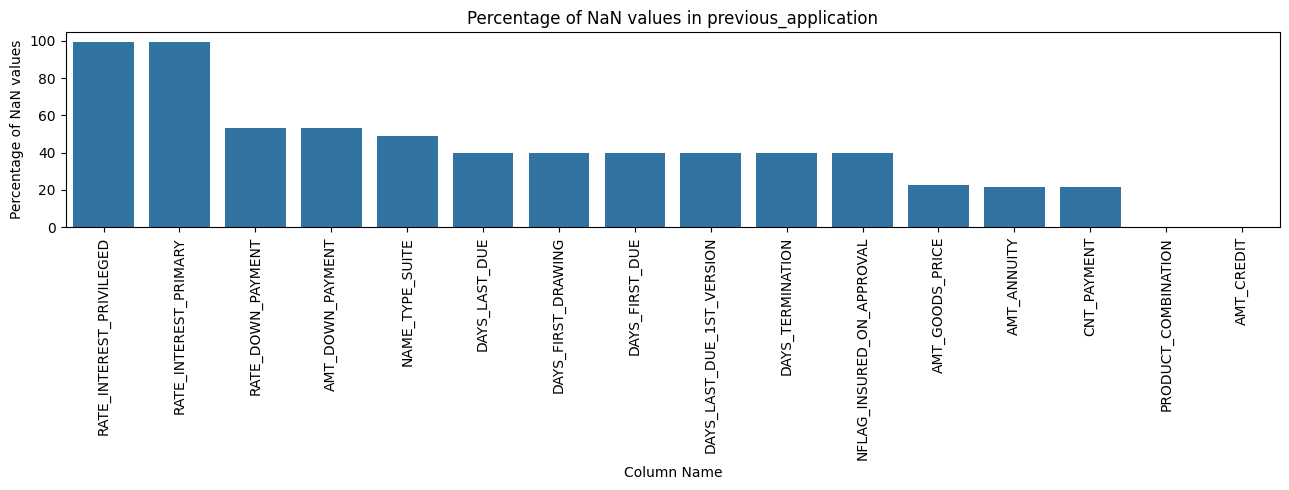

----------------------------------------------------------------------------------------------------


In [16]:
previous_application_nan = nan_df_create(previous_application)
print('-' * 100)
plot_nan_percent(previous_application_nan, 'previous_application', tight_layout = False, figsize = (13,5))
print('-' * 100)
del previous_application_nan

**Quan sát và Kết luận:**

1. Có 16 cột trong tổng số 37 cột chứa giá trị NaN.
2. Hai trong số các cột này có đến 99.64% giá trị bị thiếu, điều này là rất cao, và chúng ta cần một cách xử lý thông minh với tỷ lệ NaN cao như vậy. Hiện tại, không thể loại bỏ trực tiếp bất kỳ đặc điểm nào.
3. Ngoài hai cột này, các cột khác cũng chứa hơn 40% giá trị NaN, ngoại trừ 5 cột.

**Hợp nhất các TARGET từ application_train vào bảng previous_application.**


In [17]:
print("-"*100)
print("Merging TARGET with previous_application Table")
#prev_merged = application_train.iloc[:,:2].merge(previous_application, on = 'SK_ID_CURR', how = 'left')
prev_merged = application_train[['SK_ID_CURR', application_train.columns[1]]].merge(previous_application, on='SK_ID_CURR', how='left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with previous_application Table
----------------------------------------------------------------------------------------------------


**Phi-K Matrix**

----------------------------------------------------------------------------------------------------


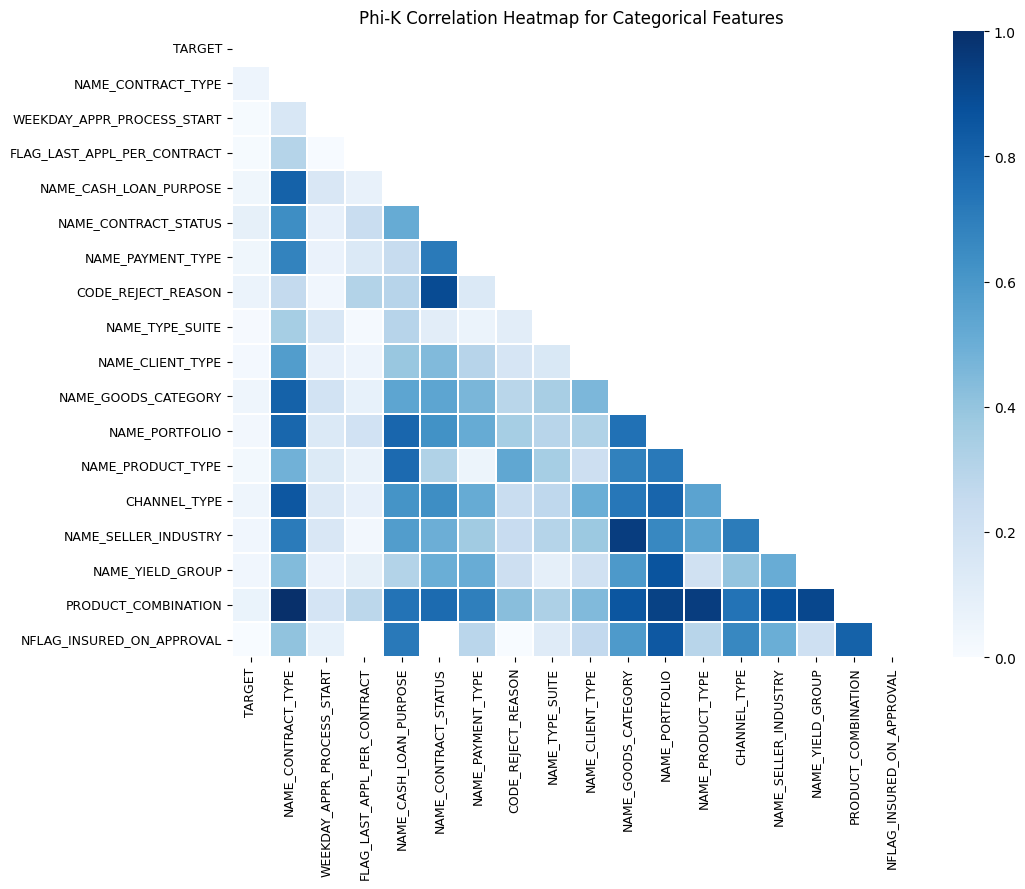

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


,Column Name,Phik-Correlation
4,NAME_CONTRACT_STATUS,0.086879
15,PRODUCT_COMBINATION,0.064961
6,CODE_REJECT_REASON,0.061816
0,NAME_CONTRACT_TYPE,0.050952
12,CHANNEL_TYPE,0.049091
9,NAME_GOODS_CATEGORY,0.046869
3,NAME_CASH_LOAN_PURPOSE,0.040725
5,NAME_PAYMENT_TYPE,0.039151
13,NAME_SELLER_INDUSTRY,0.038537
14,NAME_YIELD_GROUP,0.035383


----------------------------------------------------------------------------------------------------


In [18]:
cols_for_phik = ['TARGET'] + prev_merged.dtypes[prev_merged.dtypes == 'object'].index.tolist() + ['NFLAG_INSURED_ON_APPROVAL']
plot_phik_matrix(prev_merged, cols_for_phik, cmap = 'Blues', figsize = (11,9), fontsize = 9)

**Quan sát và Kết luận:**

Từ heatmap trên của giá trị Hệ số Phi-K cho các đặc điểm phân loại, chúng ta quan sát được rằng:

1. Đặc điểm PRODUCT_COMBINATION có sự liên kết với nhiều đặc điểm khác như NAME_CONTRACT_TYPE, NAME_PRODUCT_TYPE, NAME_PORTFOLIO, v.v.
2. Đặc điểm NAME_GOODS_CATEGORY cũng có sự liên kết cao với NAME_SELLER_INDUSTRY.
3. Nếu nhìn vào sự liên kết với biến TARGET, ta thấy rằng các đặc điểm NAME_CONTRACT_STATUS, PRODUCT_COMBINATION, CODE_REJECT_REASON là những đặc điểm có liên kết cao nhất và cần được điều tra thêm.

**Ma trận Tương quan của Các Đặc điểm**


----------------------------------------------------------------------------------------------------


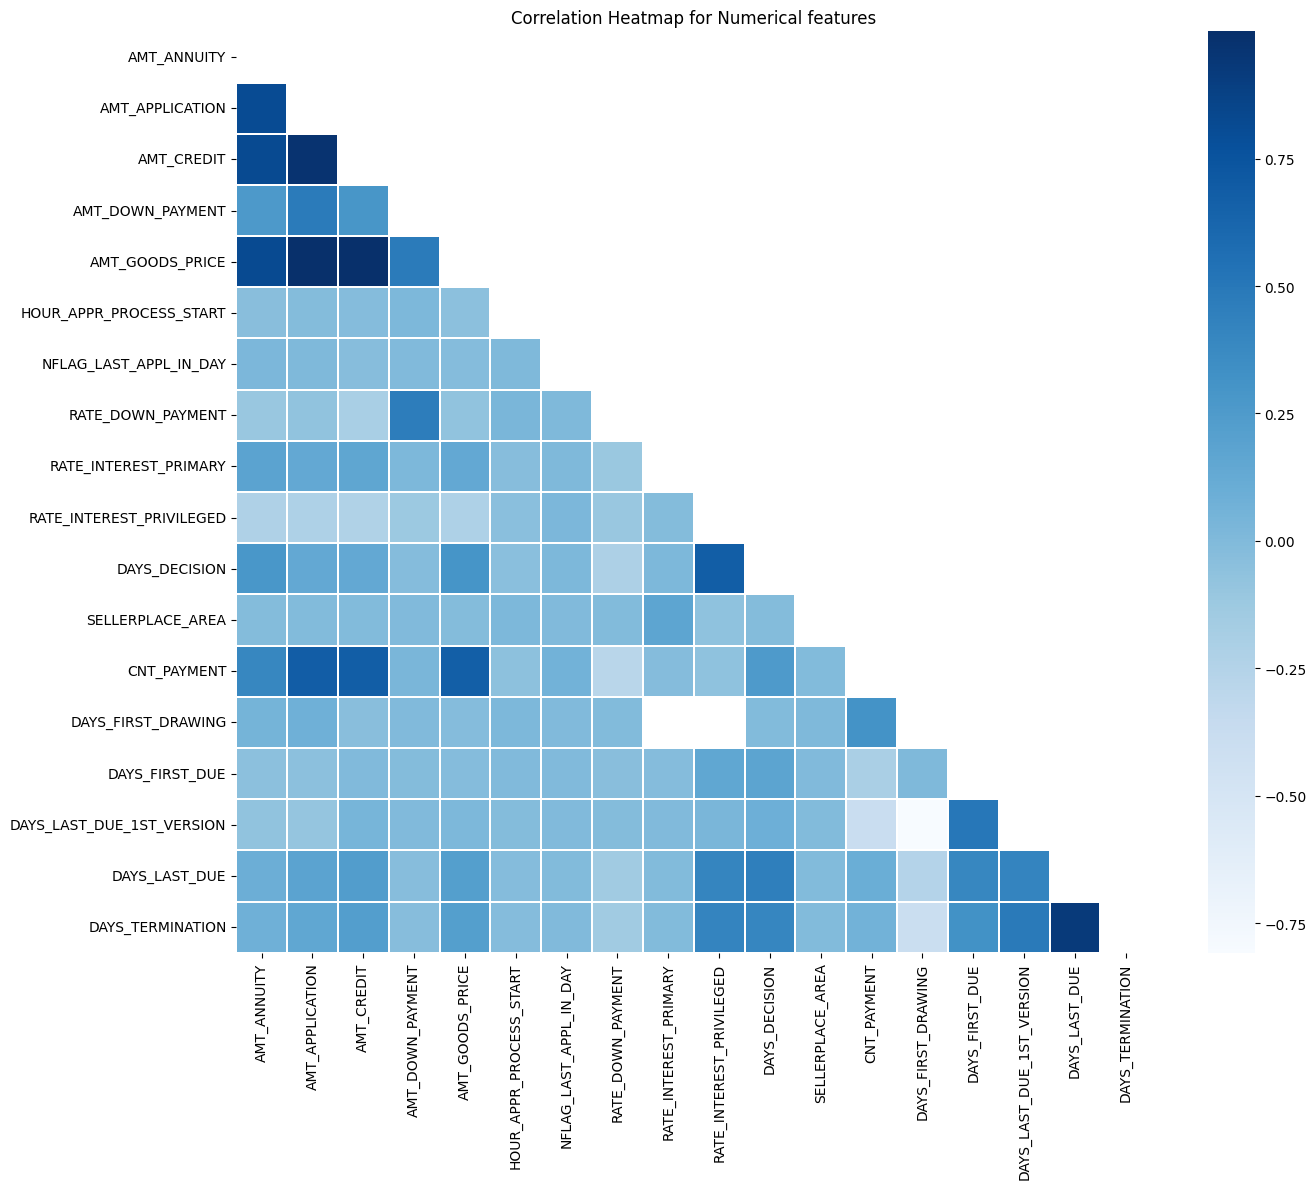

----------------------------------------------------------------------------------------------------


In [19]:
corr_mat = correlation_matrix(prev_merged, ['SK_ID_CURR','SK_ID_PREV','NFLAG_INSURED_ON_APPROVAL'], cmap = 'Blues', figsize = (14,12))
corr_mat.plot_correlation_matrix()

In [20]:
#Seeing the top columns with highest phik-correlation with the target variable in previous_applications table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_APPLICATION']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'NFLAG_LAST_APPL_IN_DAY']
interval columns not set, guessing: ['TARGET', 'RATE_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIMARY']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIVILEGED']
interval columns not set, guessing: ['TARGET', 'DAYS_DECISION']
interval columns not set, guessing: ['TARGET', 'SELLERPLACE_AREA']
interval columns not set, guessing: ['TARGET', 'CNT_PAYMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_FIRST_DRAWING']
interval columns not set, guessing: ['TARGET', 'DAYS_F

,Column Name,Phik-Correlation
12,CNT_PAYMENT,0.055758
10,DAYS_DECISION,0.051834
13,DAYS_FIRST_DRAWING,0.050492
9,RATE_INTEREST_PRIVILEGED,0.050454
7,RATE_DOWN_PAYMENT,0.038581
5,HOUR_APPR_PROCESS_START,0.035346
15,DAYS_LAST_DUE_1ST_VERSION,0.028815
16,DAYS_LAST_DUE,0.026716
17,DAYS_TERMINATION,0.026109
0,AMT_ANNUITY,0.014007


----------------------------------------------------------------------------------------------------


**Quan sát và Kết luận**

1. Biểu đồ nhiệt phía trên cho thấy mối tương quan giữa từng đặc trưng trong bảng `previous_application` với các đặc trưng còn lại.  
2. Từ biểu đồ nhiệt, ta có thể thấy một số đặc trưng có mối tương quan cao, được biểu thị bằng màu sắc đậm hơn.  
3. Mối tương quan cao đặc biệt được quan sát ở các đặc trưng sau:  
   - `DAYS_TERMINATION` và `DAYS_LAST_DUE`  
   - `AMT_CREDIT` và `AMT_APPLICATION`  
   - `AMT_APPLICATION` và `AMT_GOODS_PRICE`  
   - `AMT_CREDIT` và `AMT_ANNUITY`  
   - `AMT_ANNUITY` và `AMT_CREDIT`  
   - `AMT_CREDIT` và `AMT_GOODS_PRICE`  
4. Chúng ta cũng có thể thấy rằng các đặc trưng này không cho thấy mối tương quan tốt/cao với biến `Target`. Điều này ngụ ý rằng không có nhiều mối quan hệ tuyến tính trực tiếp giữa `Target` và các đặc trưng.

### **Biểu đồ các Biến Phân Loại**

Hãy cùng vẽ một số biến phân loại trong bảng `previous_application` và xem chúng ảnh hưởng như thế nào đến biến `Target`.

**Phân phối của Biến Phân Loại `NAME_CONTRACT_TYPE`**

Cột này mô tả loại hợp đồng của khoản vay trước đây với Credit Risk Dataset.


----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_TYPE' are:
['Cash loans' 'Consumer loans' 'Revolving loans' nan 'XNA']
----------------------------------------------------------------------------------------------------
Counts of each category are:
NAME_CONTRACT_TYPE
Cash loans         502026
Consumer loans     499786
Revolving loans    128842
XNA                   237
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_CONTRACT_TYPE = 5


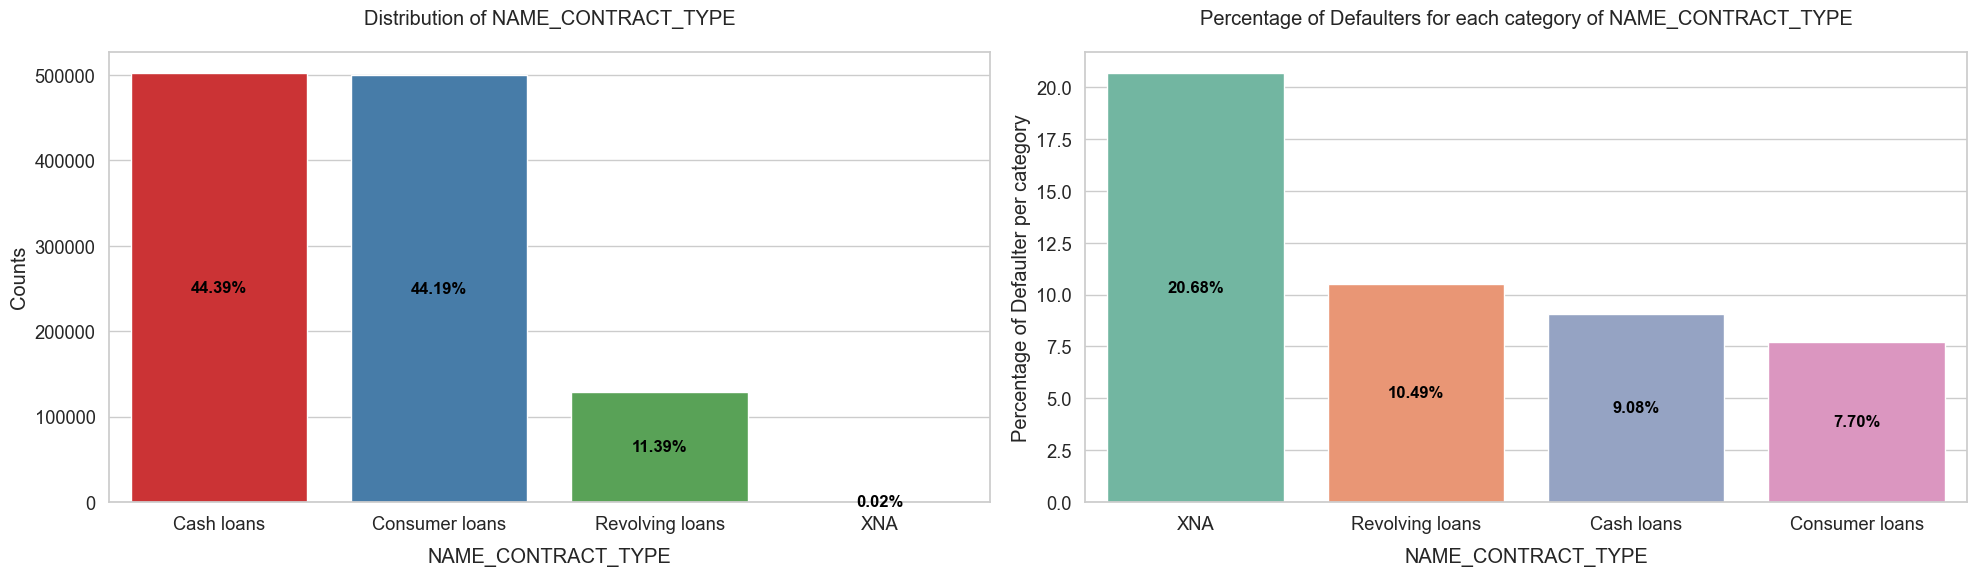

----------------------------------------------------------------------------------------------------


In [21]:
#the unique categories of 'NAME_CONTRACT_TYPE'
print_unique_categories(prev_merged, 'NAME_CONTRACT_TYPE', show_counts = True)

plot_categorical_variables_bar(prev_merged, 'NAME_CONTRACT_TYPE', horizontal_adjust = 0.3, figsize = (20, 6))
print('-'*100)

##### **Quan sát và Kết luận:**

Từ các biểu đồ phía trên, chúng ta có thể quan sát những điều sau:

<ol>
    <li>Từ biểu đồ đầu tiên, chúng ta thấy rằng hầu hết các khoản vay trước đây là <strong>Cash Loans</strong> hoặc <strong>Consumer Loans</strong>, chiếm khoảng 44% mỗi loại. 11.41% còn lại là <strong>Revolving Loans</strong>, và có một số khoản vay được gọi là <strong>XNA</strong>, loại này thực sự không rõ, nhưng số lượng rất ít.</li>
    <li>Quan sát biểu đồ thứ hai, ta thấy rằng tỷ lệ vỡ nợ cao nhất thuộc về loại khoản vay <strong>XNA</strong>, với tỷ lệ vỡ nợ là 20%. Tỷ lệ vỡ nợ cao tiếp theo là ở <strong>Revolving Loans</strong>, gần 10.5%.</li>
    <li>Các khoản <strong>Cash Loans</strong> có tỷ lệ vỡ nợ thấp hơn, khoảng 9%, trong khi các khoản <strong>Consumer Loans</strong> có tỷ lệ vỡ nợ thấp nhất, gần 7.5%.</li>
</ol>


### **Phân phối của Biến Phân Loại `NAME_CASH_LOAN_PURPOSE`**


----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CASH_LOAN_PURPOSE' are:
['XNA' 'XAP' nan 'Other' 'Repairs' 'Buying a used car' 'Education'
 'Buying a new car' 'Everyday expenses' 'Medicine' 'Car repairs'
 'Urgent needs' 'Buying a holiday home / land'
 'Building a house or an annex' 'Payments on other loans' 'Furniture'
 'Purchase of electronic equipment' 'Wedding / gift / holiday' 'Journey'
 'Business development' 'Buying a home' 'Gasification / water supply'
 'Buying a garage' 'Hobby' 'Money for a third person'
 'Refusal to name the goal']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_CASH_LOAN_PURPOSE = 26


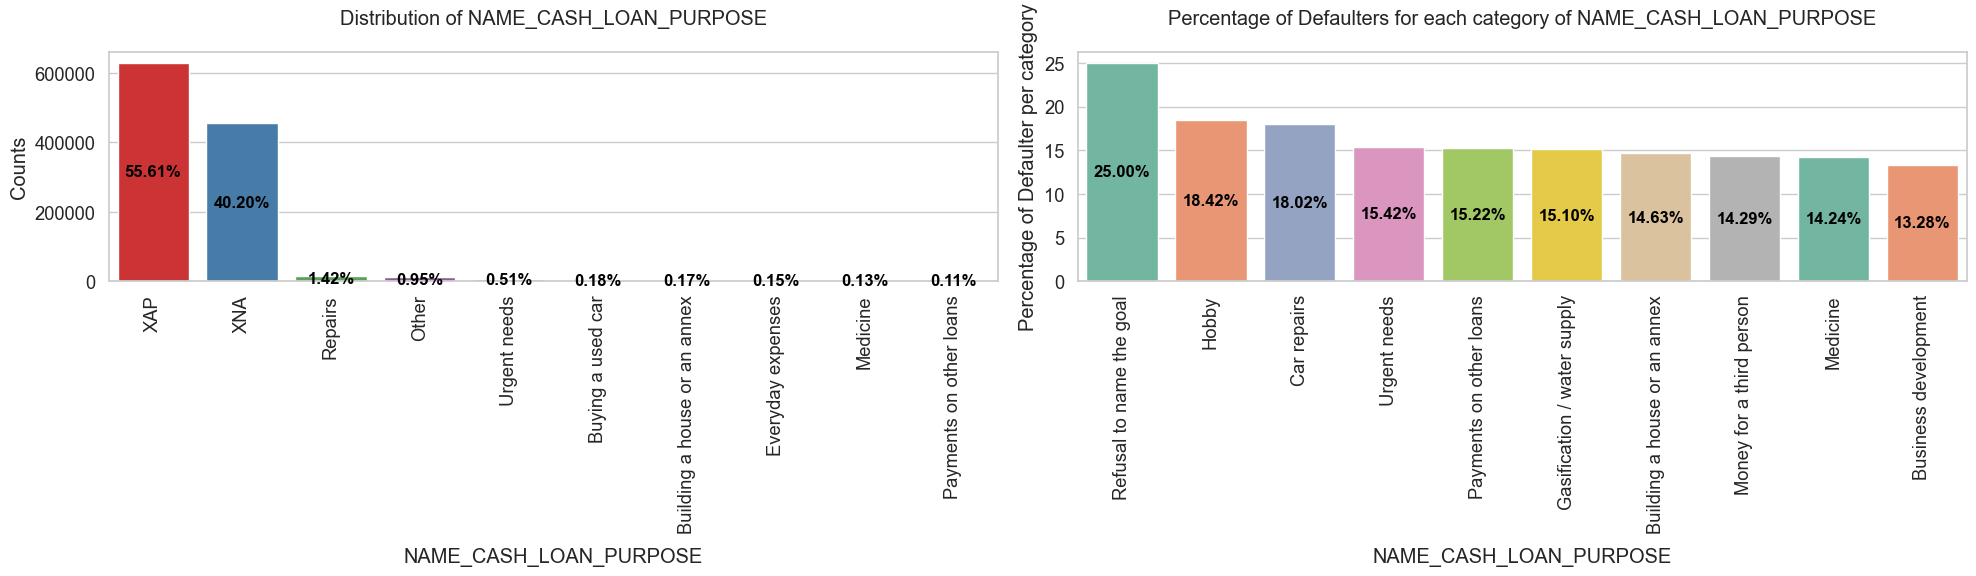

----------------------------------------------------------------------------------------------------


In [22]:
print_unique_categories(prev_merged, 'NAME_CASH_LOAN_PURPOSE')

plot_categorical_variables_bar(prev_merged, 'NAME_CASH_LOAN_PURPOSE', horizontal_adjust = 0.25, figsize = (20, 6), fontsize_percent = 'small', rotation=90)
print('-'*100)

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân bổ mục đích của các khoản vay tiền mặt và tỷ lệ vỡ nợ tương ứng cho mỗi mục đích. Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li>Phần lớn các khoản vay tiền mặt được sử dụng cho mục đích không rõ ràng, với <strong>XAP</strong> và <strong>XNA</strong> chiếm <strong>55.61%</strong> và <strong>40.20%</strong> tổng số khoản vay. Điều này cho thấy sự thiếu minh bạch trong việc ghi chép mục đích vay, hoặc người vay có thể không muốn tiết lộ mục đích cụ thể của khoản vay.</li>
    <li>Các mục đích vay khác như <strong>Repairs</strong>, <strong>Other</strong>, và <strong>Urgent needs</strong> chiếm tỷ lệ rất nhỏ, dưới <strong>2%</strong> mỗi loại, điều này cho thấy rằng phần lớn các khoản vay không được gán cho các mục đích cụ thể hoặc phổ biến.</li>
    <li><strong>Refusal to name the goal</strong> là mục đích vay có tỷ lệ vỡ nợ cao nhất, lên tới <strong>25%</strong>. Điều này có thể cho thấy rằng những khoản vay không rõ mục đích sử dụng có nguy cơ cao vỡ nợ. Các mục đích vay cho <strong>Hobby</strong>, <strong>Car repairs</strong>, và <strong>Urgent needs</strong> cũng có tỷ lệ vỡ nợ khá cao, lần lượt là <strong>18.42%</strong>, <strong>18.02%</strong>, và <strong>15.42%</strong>. Mặt khác, các khoản vay dành cho <strong>Medicine</strong> và <strong>Business development</strong> có tỷ lệ vỡ nợ tương đối thấp (<strong>14.24%</strong> và <strong>13.28%</strong>), điều này cho thấy các khoản vay cho mục đích chăm sóc sức khỏe hoặc phát triển kinh doanh có thể được coi là quan trọng hơn và được quản lý tốt hơn.</li>
</ol>

**Các kết quả này cung cấp thông tin quan trọng cho các nhà phân tích rủi ro và nhà hoạch định chính sách về việc cần cải thiện tính minh bạch và đánh giá rủi ro trong việc cho vay tiền mặt, đặc biệt là việc xác định mục đích vay rõ ràng để giảm thiểu rủi ro vỡ nợ.**


### **Phân phối của Biến Phân Loại `NAME_TYPE_SUITE`**

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_TYPE_SUITE' are:
['Unaccompanied' 'Family' nan 'Children' 'Other_A' 'Spouse, partner'
 'Other_B' 'Group of people']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_TYPE_SUITE = 8


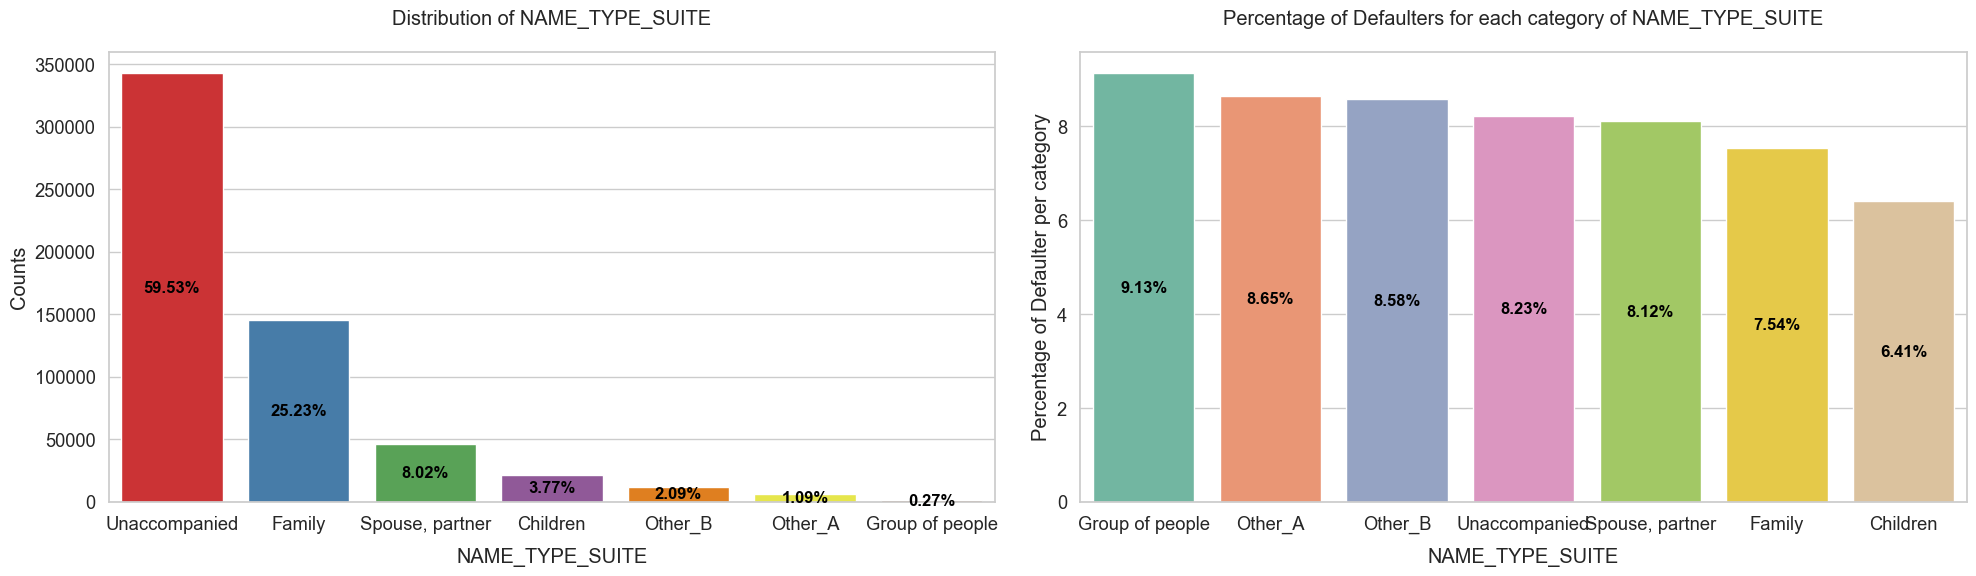

----------------------------------------------------------------------------------------------------


In [23]:

print_unique_categories(prev_merged, 'NAME_TYPE_SUITE')

plot_categorical_variables_bar(prev_merged, 'NAME_TYPE_SUITE', horizontal_adjust = 0.25, figsize = (20, 6), fontsize_percent = 'small')
print('-'*100)

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối của các loại người đồng hành khi nộp đơn và tỷ lệ vỡ nợ tương ứng cho mỗi loại. Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li>Phần lớn các đơn vay được nộp một mình, với <strong>Unaccompanied</strong> chiếm khoảng <strong>59.53%</strong>. Điều này cho thấy rằng hầu hết các ứng viên thích nộp đơn độc lập mà không có sự đồng hành của người khác.</li>
    <li><strong>Family</strong> là nhóm đồng hành thứ hai phổ biến nhất, chiếm <strong>25.23%</strong>. Nhóm này bao gồm các ứng viên đi cùng với thành viên gia đình khi nộp đơn.</li>
    <li><strong>Spouse, partner</strong> chiếm <strong>8.02%</strong>, cho thấy một số người vay chọn đi cùng với bạn đời hoặc đối tác khi làm thủ tục vay vốn.</li>
    <li>Các nhóm khác như <strong>Children</strong>, <strong>Other_B</strong>, và <strong>Other_A</strong> có tỷ lệ tham gia thấp hơn nhiều, dưới <strong>5%</strong> cho mỗi nhóm.</li>
    <li>Tỷ lệ vỡ nợ cao nhất là ở nhóm <strong>Group of people</strong>, với khoảng <strong>9.13%</strong>. Điều này có thể chỉ ra rằng các đơn vay với nhiều người đi cùng có nguy cơ cao hơn về mặt tín dụng.</li>
    <li>Người đi một mình khi nộp đơn (<strong>Unaccompanied</strong>) có tỷ lệ vỡ nợ là <strong>8.58%</strong>, trong khi những người đi cùng gia đình (<strong>Family</strong>) có tỷ lệ thấp hơn một chút là <strong>8.12%</strong>.</li>
    <li>Đáng chú ý, những người nộp đơn cùng với <strong>Children</strong> có tỷ lệ vỡ nợ thấp nhất, chỉ <strong>6.41%</strong>, cho thấy rằng những người đi cùng trẻ em có thể có tình hình tài chính ổn định hơn.</li>
</ol>

**Những thông tin này có thể hỗ trợ ngân hàng và các tổ chức tín dụng khác trong việc đánh giá rủi ro tín dụng dựa trên hồ sơ đồng hành của người nộp đơn, góp phần vào việc cải thiện chiến lược cho vay và giảm thiểu rủi ro vỡ nợ.**


### **Phân phối của Biến Phân Loại `NAME_GOODS_CATEGORY`**

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_GOODS_CATEGORY' are:
['XNA' 'Furniture' 'Consumer Electronics' 'Audio/Video'
 'Construction Materials' 'Mobile' 'Gardening' 'Computers' nan
 'Photo / Cinema Equipment' 'Clothing and Accessories' 'Medical Supplies'
 'Vehicles' 'Other' 'Jewelry' 'Homewares' 'Auto Accessories'
 'Sport and Leisure' 'Medicine' 'Office Appliances' 'Tourism'
 'Direct Sales' 'Weapon' 'Fitness' 'Insurance' 'Additional Service'
 'Education']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_GOODS_CATEGORY = 27


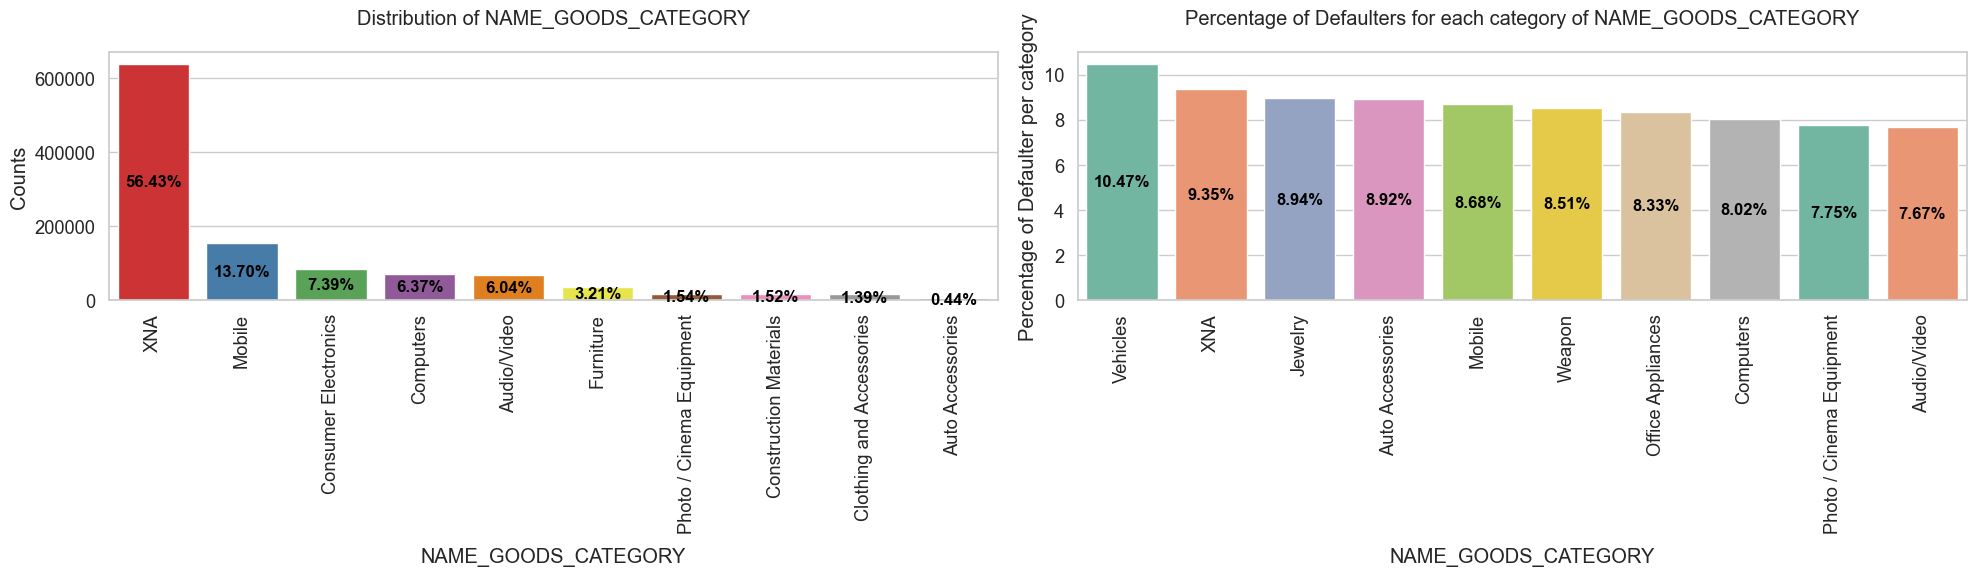

----------------------------------------------------------------------------------------------------


In [24]:

print_unique_categories(prev_merged, 'NAME_GOODS_CATEGORY')

plot_categorical_variables_bar(prev_merged, 'NAME_GOODS_CATEGORY', horizontal_adjust = 0.25, figsize = (20, 6), fontsize_percent = 'small',rotation=90)
print('-'*100)

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối của các loại hàng hóa vay vốn và tỷ lệ vỡ nợ tương ứng cho từng danh mục. Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li><strong>XNA</strong> là danh mục phổ biến nhất, chiếm <strong>56.43%</strong> tổng số các khoản vay. Điều này cho thấy rằng nhiều khoản vay không được gắn nhãn rõ ràng với danh mục hàng hóa cụ thể.</li>
    <li>Danh mục <strong>Mobile</strong> là danh mục cụ thể phổ biến nhất, chiếm <strong>13.70%</strong>, theo sau là <strong>Consumer Electronics</strong> với <strong>7.39%</strong> và <strong>Computers</strong> với <strong>6.37%</strong>.</li>
    <li>Các danh mục như <strong>Photo / Cinema Equipment</strong>, <strong>Construction Materials</strong>, và <strong>Clothing and Accessories</strong> chỉ chiếm tỷ lệ rất nhỏ, dưới <strong>2%</strong>, cho thấy rằng các khoản vay cho các danh mục này ít phổ biến.</li>
    <li>Tỷ lệ vỡ nợ cao nhất là ở danh mục <strong>Vehicles</strong>, với khoảng <strong>10.47%</strong>, cho thấy rằng các khoản vay cho xe cộ có nguy cơ cao về mặt tín dụng.</li>
    <li>Các danh mục <strong>XNA</strong>, <strong>Jewelry</strong>, và <strong>Auto Accessories</strong> cũng có tỷ lệ vỡ nợ tương đối cao, lần lượt là <strong>9.35%</strong>, <strong>8.94%</strong>, và <strong>8.92%</strong>.</li>
    <li>Danh mục <strong>Photo / Cinema Equipment</strong> và <strong>Audio / Video</strong> có tỷ lệ vỡ nợ thấp hơn, lần lượt là <strong>7.75%</strong> và <strong>7.67%</strong>, cho thấy rằng các khoản vay liên quan đến thiết bị hình ảnh và âm thanh có mức rủi ro thấp hơn một chút.</li>
</ol>

**Những thông tin này có thể hỗ trợ ngân hàng trong việc đánh giá rủi ro tín dụng và đưa ra các quyết định liên quan đến các danh mục hàng hóa cụ thể, từ đó tối ưu hóa chiến lược cho vay và giảm thiểu rủi ro vỡ nợ.**


### **Phân phối của Biến Phân Loại `NAME_SELLER_INDUSTRY`**

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_SELLER_INDUSTRY' are:
['XNA' 'Furniture' 'Consumer electronics' 'Construction' 'Connectivity'
 nan 'Clothing' 'Industry' 'Auto technology' 'Jewelry' 'Tourism'
 'MLM partners']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_SELLER_INDUSTRY = 12


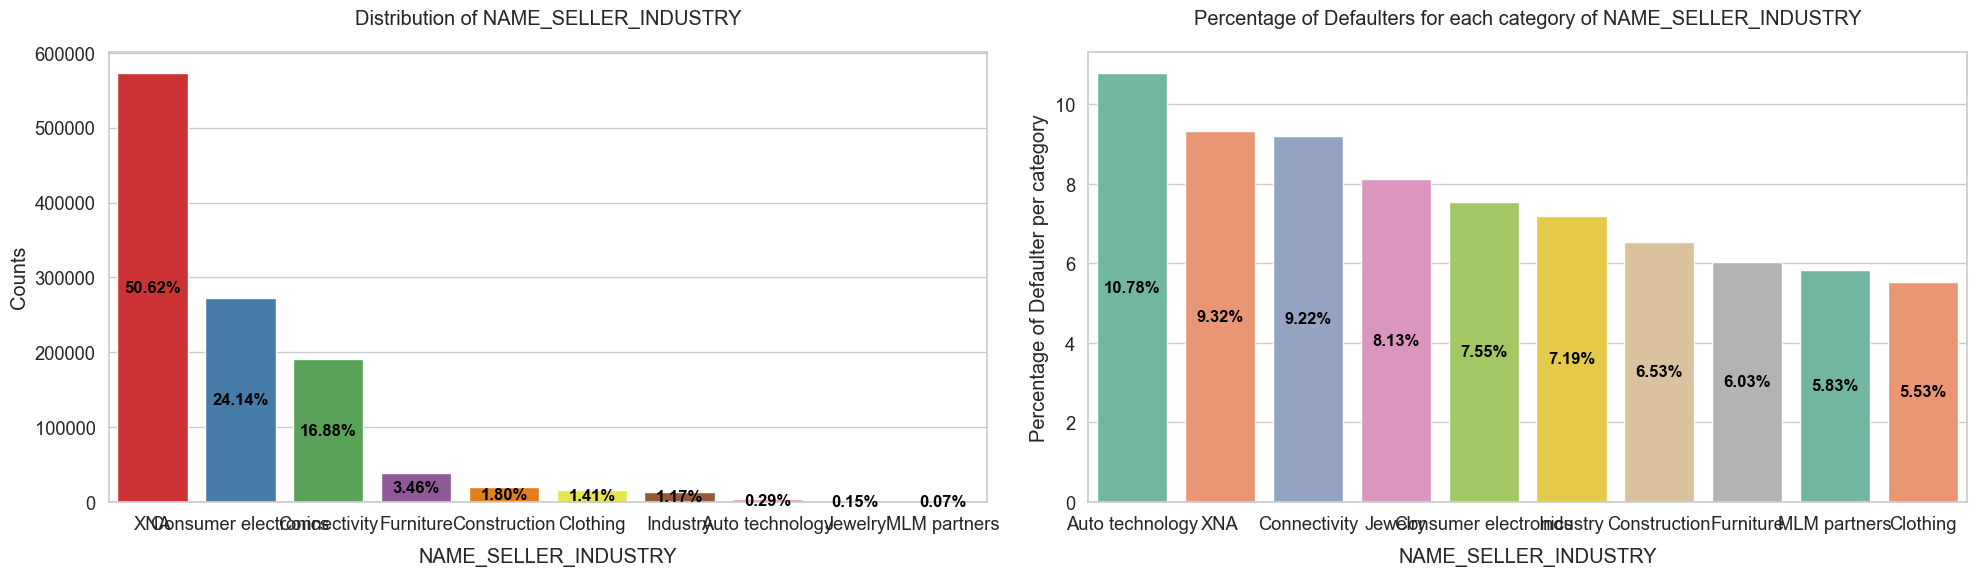

----------------------------------------------------------------------------------------------------


In [25]:

print_unique_categories(prev_merged, 'NAME_SELLER_INDUSTRY')

plot_categorical_variables_bar(prev_merged, 'NAME_SELLER_INDUSTRY', horizontal_adjust = 0.25, figsize = (20, 6), fontsize_percent = 'small')
print('-'*100)

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối của các ngành công nghiệp nơi người bán hoạt động và tỷ lệ vỡ nợ tương ứng cho từng danh mục. Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li><strong>XNA</strong> là ngành công nghiệp phổ biến nhất, chiếm <strong>50.62%</strong> tổng số các khoản vay. Điều này cho thấy rằng nhiều hồ sơ không cung cấp thông tin rõ ràng về ngành công nghiệp cụ thể của người bán.</li>
    <li>Các ngành <strong>Consumer electronics</strong> và <strong>Connectivity</strong> là hai ngành công nghiệp phổ biến tiếp theo, chiếm lần lượt <strong>24.14%</strong> và <strong>16.88%</strong>.</li>
    <li>Các ngành khác như <strong>Furniture</strong>, <strong>Construction</strong>, và <strong>Clothing</strong> chiếm tỷ lệ thấp hơn đáng kể, dưới <strong>5%</strong> cho mỗi ngành.</li>
    <li>Tỷ lệ vỡ nợ cao nhất là ở ngành <strong>Auto technology</strong>, với khoảng <strong>10.78%</strong>, cho thấy rằng các khoản vay liên quan đến ngành công nghiệp này có rủi ro tín dụng cao nhất.</li>
    <li>Ngành <strong>XNA</strong> và <strong>Connectivity</strong> cũng có tỷ lệ vỡ nợ tương đối cao, lần lượt là <strong>9.32%</strong> và <strong>9.22%</strong>.</li>
    <li>Các ngành như <strong>Furniture</strong>, <strong>Construction</strong>, và <strong>Industry</strong> có tỷ lệ vỡ nợ thấp hơn, lần lượt là <strong>7.55%</strong>, <strong>7.19%</strong>, và <strong>6.53%</strong>.</li>
    <li>Ngành <strong>Clothing</strong> có tỷ lệ vỡ nợ thấp nhất, chỉ <strong>5.53%</strong>, cho thấy rằng các khoản vay trong ngành này có xu hướng được quản lý tốt hơn.</li>
</ol>

**Những thông tin này có thể giúp các tổ chức tài chính hiểu rõ hơn về rủi ro tín dụng dựa trên ngành công nghiệp của người bán, từ đó cải thiện chiến lược cho vay và giảm thiểu nguy cơ vỡ nợ.**


### **Phân phối của Biến Phân Loại `NAME_CONTRACT_STATUS`**

Cột này mô tả trạng thái của hợp đồng của khoản vay trước đây với Credit Risk Dataset, tức là liệu nó đang hoạt động, đã đóng, v.v.


----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_STATUS' are:
['Approved' 'Canceled' 'Refused' nan 'Unused offer']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_CONTRACT_STATUS = 5


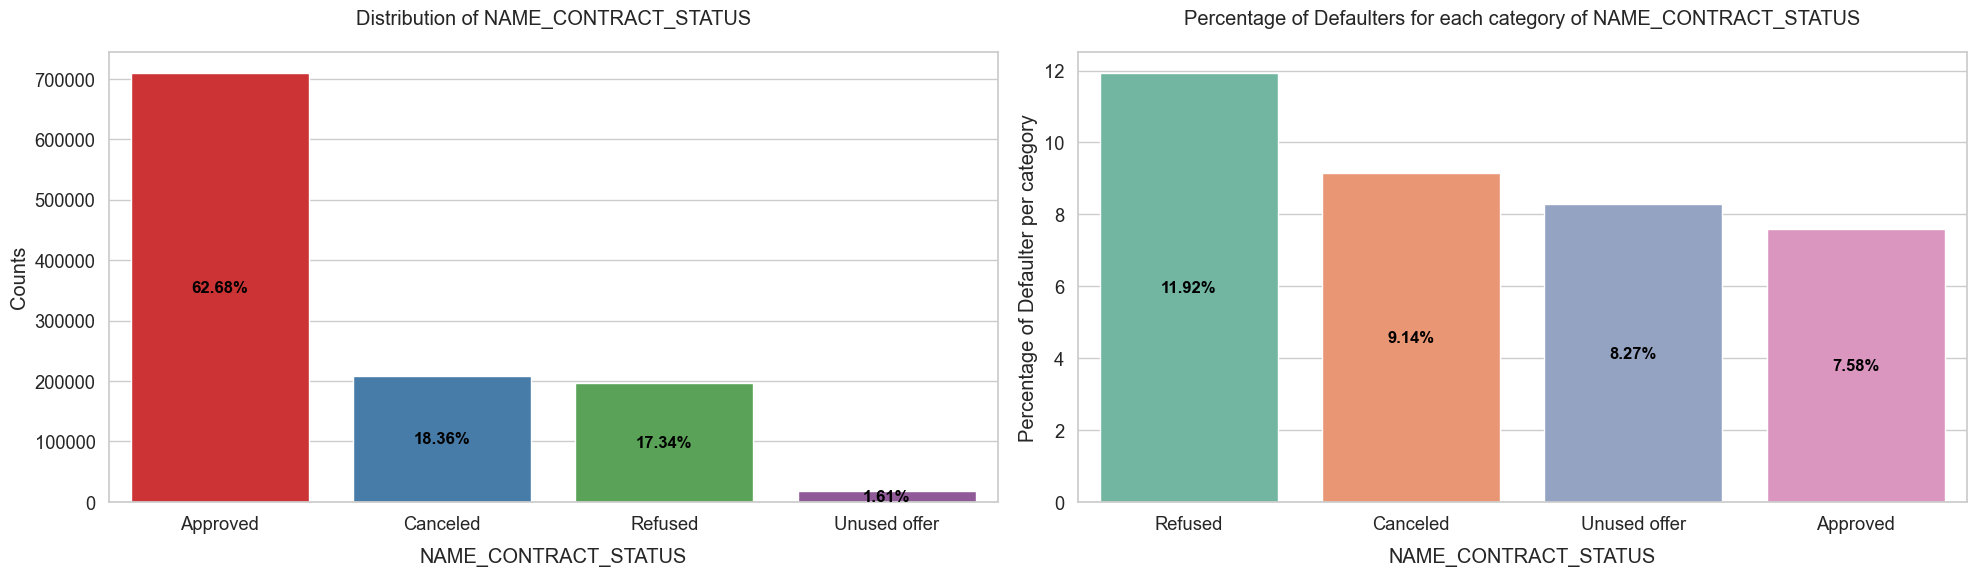

----------------------------------------------------------------------------------------------------


In [26]:

print_unique_categories(prev_merged, 'NAME_CONTRACT_STATUS')

plot_categorical_variables_bar(prev_merged, 'NAME_CONTRACT_STATUS', horizontal_adjust = 0.25, figsize = (20, 6), fontsize_percent = 'small')
print('-'*100)

##### **Quan sát và Kết luận:**

Từ các biểu đồ phía trên, chúng ta có thể thấy rằng:

<ol>
    <li>Loại trạng thái hợp đồng phổ biến nhất là trạng thái <strong>Approved</strong>. Khoảng 63% các khoản vay trước đây có trạng thái này. Hai trạng thái phổ biến tiếp theo là <strong>Canceled</strong> và <strong>Refused</strong>, cả hai chiếm khoảng 18% số khoản vay. Điều này cho thấy hầu hết các khoản vay được chấp thuận, và chỉ một phần nhỏ không được phê duyệt. Loại trạng thái hợp đồng xuất hiện ít nhất là <strong>Unused Offer</strong>, chỉ chiếm 1.61% tổng số khoản vay.</li>
    <li>Quan sát biểu đồ thứ hai về tỷ lệ vỡ nợ, ta thấy rằng các khoản vay có trạng thái <strong>Refused</strong> trước đây có xu hướng vỡ nợ cao nhất ở các khoản vay hiện tại. Chúng chiếm khoảng 12% tỷ lệ vỡ nợ trong danh mục này. Tiếp theo là trạng thái <strong>Canceled</strong>, chiếm gần 9% tỷ lệ vỡ nợ. Hành vi này khá hợp lý, vì những người này có thể đã bị từ chối trước đó do không có hồ sơ đủ điều kiện. Tỷ lệ vỡ nợ thấp nhất được quan sát ở trạng thái hợp đồng <strong>Approved</strong>.</li>
</ol>


### **Phân phối của Biến Phân Loại `CODE_REJECT_REASON`**

Cột này mô tả lý do từ chối các khoản vay đã nộp trước đây trong Credit Risk Dataset.


----------------------------------------------------------------------------------------------------
The unique categories of 'CODE_REJECT_REASON' are:
['XAP' 'LIMIT' nan 'HC' 'SCO' 'SCOFR' 'VERIF' 'CLIENT' 'XNA' 'SYSTEM']
----------------------------------------------------------------------------------------------------
Counts of each category are:
CODE_REJECT_REASON
XAP       916498
HC        116812
LIMIT      38037
SCO        26096
CLIENT     18263
SCOFR       8697
XNA         3521
VERIF       2452
SYSTEM       515
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of CODE_REJECT_REASON = 10


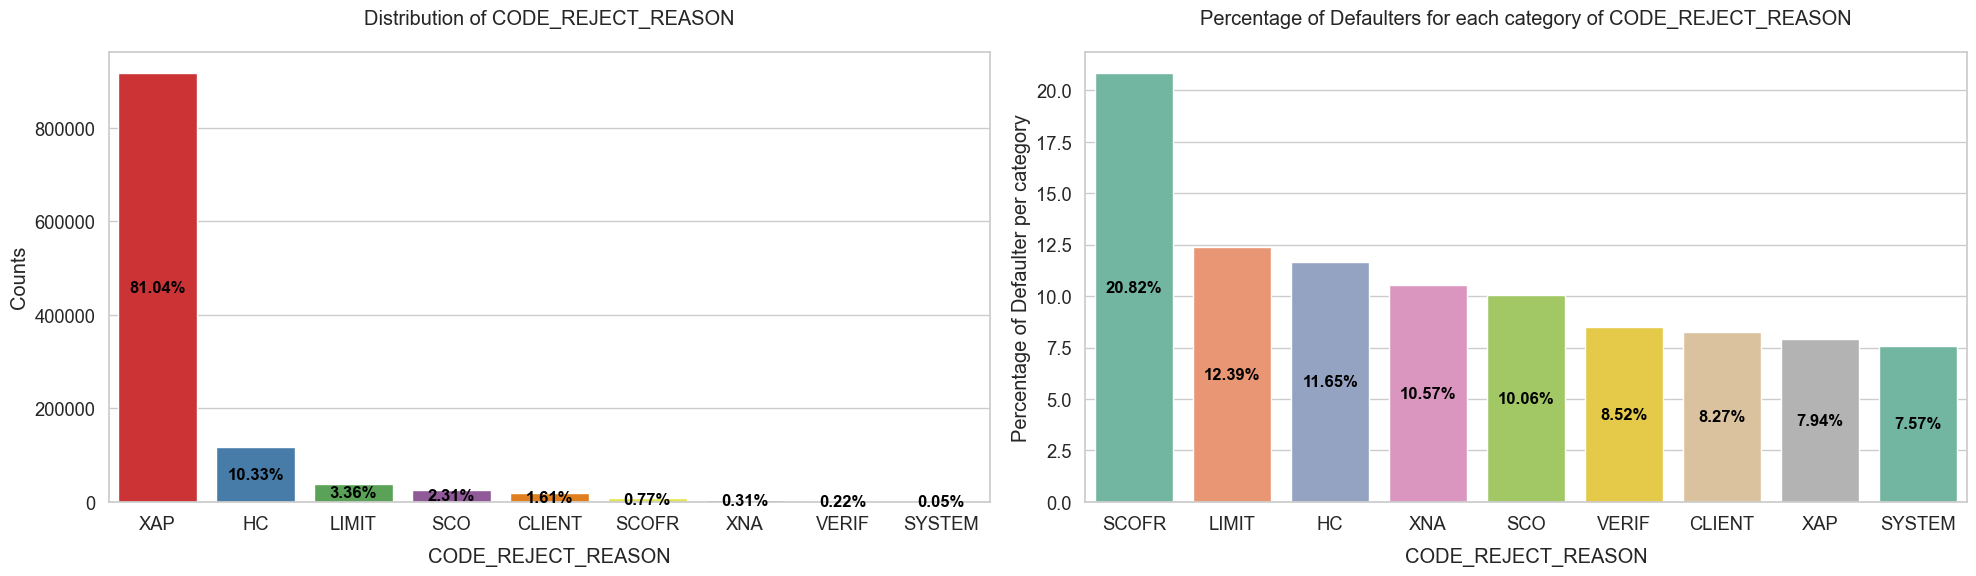

----------------------------------------------------------------------------------------------------


In [27]:

print_unique_categories(prev_merged, 'CODE_REJECT_REASON', show_counts = True)

plot_categorical_variables_bar(prev_merged, 'CODE_REJECT_REASON', horizontal_adjust = 0.18, figsize = (20, 6))
print('-'*100)

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối của biến phân loại `CODE_REJECT_REASON`. Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li>Lý do từ chối phổ biến nhất là <strong>XAP</strong>, chiếm khoảng ~81%. Các lý do khác chỉ chiếm một phần nhỏ trong các lý do từ chối. <strong>HC</strong> là lý do từ chối cao thứ hai, với chỉ 10.33% số lần xuất hiện.</li>
    <li>Phân phối tỷ lệ vỡ nợ cho từng loại trong `CODE_REJECT_REASON` khá thú vị. Những ứng viên có đơn đăng ký trước đây bị từ chối với mã <strong>SCOFT</strong> có tỷ lệ vỡ nợ cao nhất (~21%). Tiếp theo là các mã <strong>LIMIT</strong> và <strong>HC</strong>, với khoảng 12.5% và 12% tỷ lệ vỡ nợ.</li>
    <li>Lý do từ chối phổ biến nhất <strong>XAP</strong> chỉ chiếm 7.5% tổng số người vỡ nợ, và đây là tỷ lệ thấp thứ hai sau mã <strong>SYSTEM</strong>.</li>
</ol>


### **Phân phối của Biến Phân Loại `CHANNEL_TYPE`**

Cột này mô tả kênh mà khách hàng đã được tiếp cận cho khoản vay trước đây trong Credit Risk Dataset.


----------------------------------------------------------------------------------------------------
The unique categories of 'CHANNEL_TYPE' are:
['Credit and cash offices' 'Stone' 'Country-wide' 'Regional / Local'
 'AP+ (Cash loan)' 'Contact center' nan 'Channel of corporate sales'
 'Car dealer']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of CHANNEL_TYPE = 9


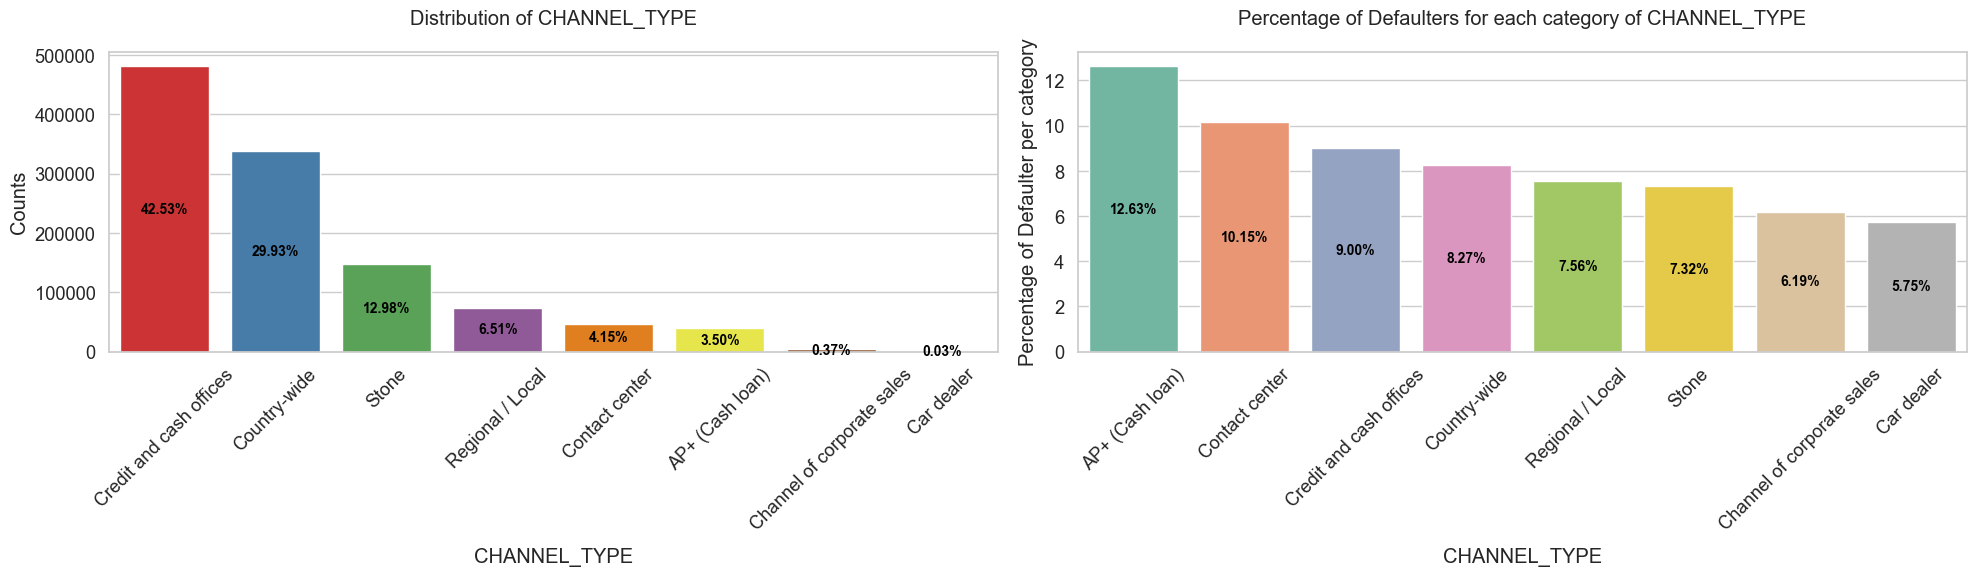

----------------------------------------------------------------------------------------------------


In [28]:

print_unique_categories(prev_merged, 'CHANNEL_TYPE')

plot_categorical_variables_bar(prev_merged, 'CHANNEL_TYPE', horizontal_adjust = 0.15, rotation = 45, figsize = (20, 6), fontsize_percent = 'x-small')
print('-'*100)

##### **Quan sát và Kết luận**

Hai biểu đồ phía trên cho thấy phân phối của `CHANNEL_TYPE` cho các khoản vay trước đây trong Credit Risk Dataset.

<ol>
    <li>Từ biểu đồ đầu tiên, ta thấy rằng phần lớn các đơn vay được tiếp cận qua kênh <strong>Credit and cash offices</strong>, chiếm khoảng 42.47% tổng số đơn vay, tiếp theo là kênh <strong>Country-wide</strong> với 29.93%. Các loại kênh còn lại chỉ chiếm một số ít đơn vay.</li>
    <li>Tỷ lệ vỡ nợ cao nhất được ghi nhận ở những đơn vay qua kênh <strong>AP+ (Cash loan)</strong>, chiếm khoảng 13% trong danh mục này. Các kênh còn lại có tỷ lệ vỡ nợ thấp hơn. Kênh <strong>Car Dealer</strong> cho thấy tỷ lệ vỡ nợ thấp nhất, chỉ 5%.</li>
</ol>


### **Phân phối của Biến Phân Loại `PRODUCT_COMBINATION`**

Cột này cung cấp thông tin chi tiết về sự kết hợp sản phẩm của các đơn vay trước đây.


----------------------------------------------------------------------------------------------------
The unique categories of 'PRODUCT_COMBINATION' are:
['Cash X-Sell: low' 'POS industry with interest'
 'POS household with interest' 'Card Street' 'Card X-Sell'
 'Cash X-Sell: high' 'Cash' 'Cash Street: high' 'Cash X-Sell: middle'
 'POS mobile with interest' 'POS industry without interest'
 'Cash Street: low' 'POS other with interest'
 'POS household without interest' 'POS mobile without interest' nan
 'Cash Street: middle' 'POS others without interest']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of PRODUCT_COMBINATION = 18


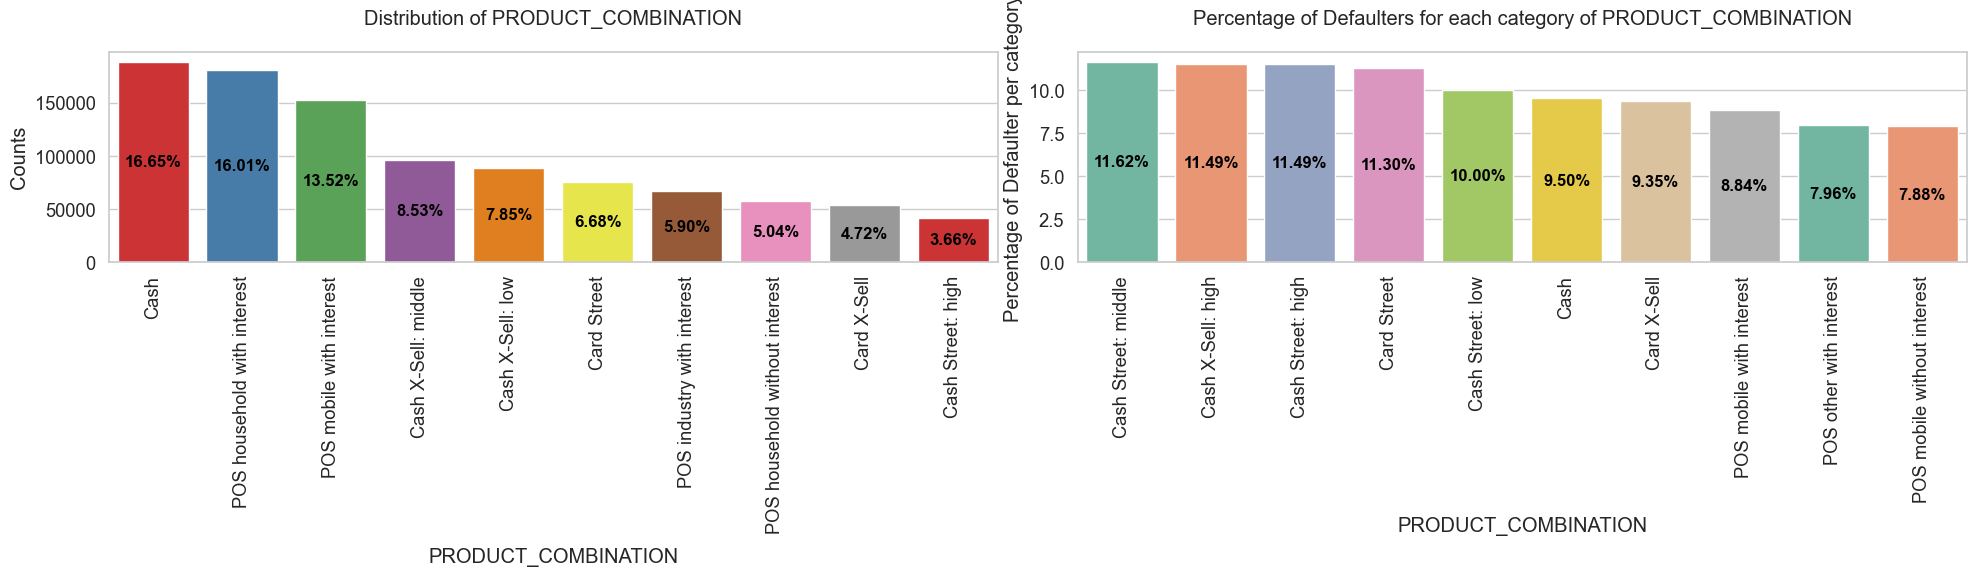

----------------------------------------------------------------------------------------------------


In [29]:

print_unique_categories(prev_merged, 'PRODUCT_COMBINATION')

plot_categorical_variables_bar(prev_merged, 'PRODUCT_COMBINATION', rotation = 90, figsize = (20, 6))
print('-'*100)

##### **Quan sát và Kết luận**

Từ phân phối của `PRODUCT_COMBINATION`, chúng ta có thể rút ra những nhận định sau:

<ol>
    <li>Ba loại kết hợp sản phẩm phổ biến nhất là <strong>Cash</strong>, <strong>POS household with interest</strong> và <strong>POS mobile with interest</strong>. Chúng chiếm khoảng 50% tổng số các đơn vay.</li>
    <li>Quan sát biểu đồ tỷ lệ vỡ nợ theo từng loại, ta thấy xu hướng vỡ nợ cao nhất thuộc về các danh mục <strong>Cash Street: mobile</strong>, <strong>Cash X-sell: high</strong>, <strong>Cash Street: high</strong> và <strong>Card Street</strong>, với tỷ lệ vỡ nợ khoảng 11-11.5% cho mỗi danh mục. Tỷ lệ vỡ nợ thấp nhất nằm trong danh mục <strong>POS Industry without interest</strong>, chỉ chiếm khoảng 4.5%.</li>
</ol>


#### **Vẽ Biểu Đồ cho Các Biến Liên Tục**



<u><b>Phân phối của Biến Liên Tục với các Đặc trưng `DAYS`</b></u>  
**DAYS_DECISION**  

Cột này cho biết số ngày so với đơn vay hiện tại khi quyết định được đưa ra cho đơn vay trước đó.


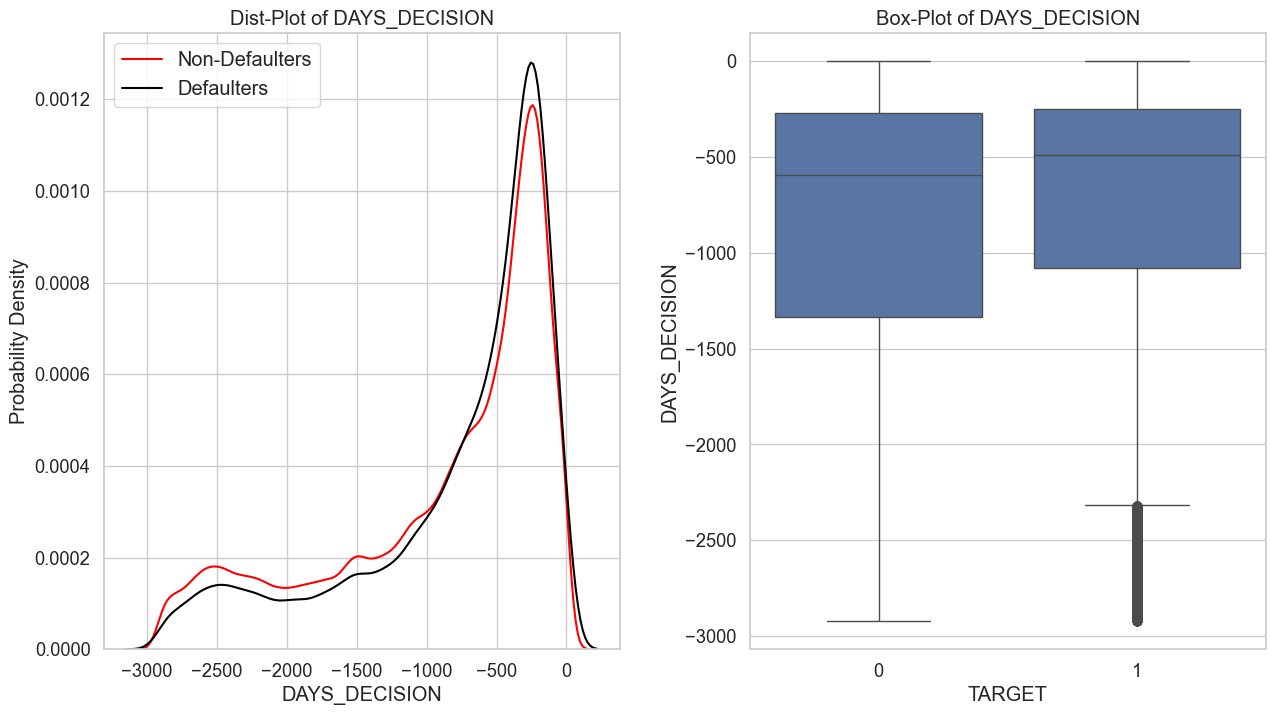

In [30]:
plot_continuous_variables(prev_merged, 'DAYS_DECISION', plots = ['distplot', 'box'], figsize = (15,8))

##### **Quan sát và Kết luận**

Từ biểu đồ trên, chúng ta nhận thấy rằng đối với những người vỡ nợ, số ngày trước khi quyết định được đưa ra ít hơn một chút so với những người không vỡ nợ. Điều này ngụ ý rằng những người vỡ nợ thường có quyết định về các đơn vay trước đó được đưa ra gần đây hơn so với những người không vỡ nợ.


**DAYS_FIRST_DRAWING**  

Cột này cho biết số ngày trước từ đơn vay hiện tại khi khoản giải ngân đầu tiên của đơn vay trước đó được thực hiện.


----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_FIRST_DRAWING is -2922.0
The 1th percentile value of DAYS_FIRST_DRAWING is -2454.0
The 2th percentile value of DAYS_FIRST_DRAWING is -1182.0
The 3th percentile value of DAYS_FIRST_DRAWING is -675.0
The 4th percentile value of DAYS_FIRST_DRAWING is -405.0
The 5th percentile value of DAYS_FIRST_DRAWING is -262.0
The 6th percentile value of DAYS_FIRST_DRAWING is -152.23999999999796
The 7th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 8th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 9th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 10th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 20th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 40th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 60th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 80th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 100

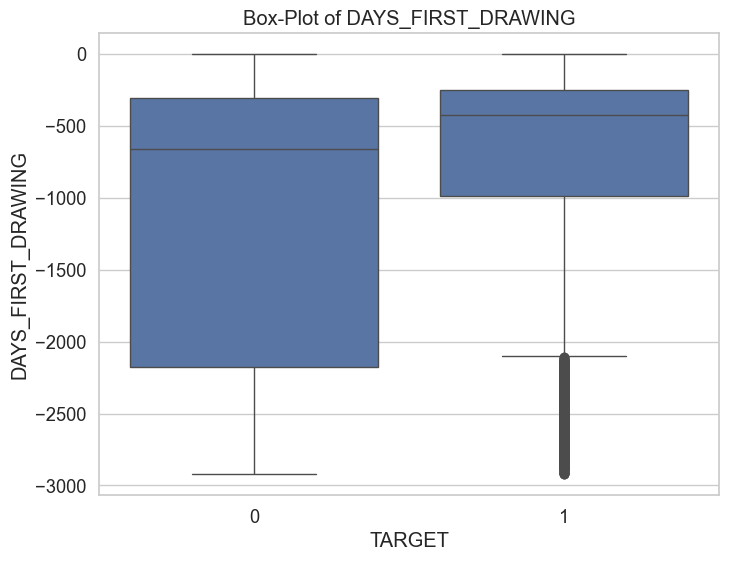

----------------------------------------------------------------------------------------------------


In [31]:
print_percentiles(prev_merged, 'DAYS_FIRST_DRAWING', percentiles = list(range(0,11)) + list(range(20,101,20)))
plot_continuous_variables(prev_merged, 'DAYS_FIRST_DRAWING', plots = ['box'], figsize = (8,6), scale_limits = [-3000,0])
print('-'*100)

##### **Quan sát và Kết luận**

<ol>
    <li>Khi quan sát các giá trị phần trăm của `DAYS_FIRST_DRAWING`, có vẻ như hầu hết các giá trị là lỗi, bắt đầu từ giá trị phần trăm thứ 7 trở đi. Các giá trị lỗi này cần được loại bỏ.</li>
    <li>Nếu phân tích phân phối của cột này sau khi loại bỏ các giá trị lỗi, ta thấy rằng phần lớn những người vỡ nợ có lần giải ngân đầu tiên trên khoản vay trước đó gần đây hơn so với những người không vỡ nợ. Giá trị phần trăm thứ 75 cho những người vỡ nợ cũng thấp hơn đáng kể so với những người không vỡ nợ.</li>
</ol>


**DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, and DAYS_TERMINATION**  

Các cột này cũng mô tả số ngày trước từ đơn vay hiện tại khi một số hoạt động nhất định diễn ra.


In [32]:
print('-'*100)
print("Percentile Values for DAYS_FIRST_DUE")
print_percentiles(prev_merged, 'DAYS_FIRST_DUE', percentiles = list(range(0,11,2)) + [20,40,60,80,100])
print("Percentile Values for DAYS_LAST_DUE_1ST_VERSION")
print_percentiles(prev_merged, 'DAYS_LAST_DUE_1ST_VERSION', percentiles = list(range(0,11,2)) + [20,40,60,80,100])
print("Percentile Values for DAYS_LAST_DUE")
print_percentiles(prev_merged, 'DAYS_LAST_DUE', percentiles = list(range(0,11,2)) + [20,40,60,80,100])
print("Percentile Values for DAYS_TERMINATION")
print_percentiles(prev_merged, 'DAYS_TERMINATION', percentiles = list(range(0,11,2)) + [20,40,60,80,100])

----------------------------------------------------------------------------------------------------
Percentile Values for DAYS_FIRST_DUE
----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_FIRST_DUE is -2892.0
The 2th percentile value of DAYS_FIRST_DUE is -2759.0
The 4th percentile value of DAYS_FIRST_DUE is -2649.0
The 6th percentile value of DAYS_FIRST_DUE is -2556.0
The 8th percentile value of DAYS_FIRST_DUE is -2472.0
The 10th percentile value of DAYS_FIRST_DUE is -2389.0
The 20th percentile value of DAYS_FIRST_DUE is -1883.0
The 40th percentile value of DAYS_FIRST_DUE is -1069.0
The 60th percentile value of DAYS_FIRST_DUE is -647.0
The 80th percentile value of DAYS_FIRST_DUE is -329.0
The 100th percentile value of DAYS_FIRST_DUE is 365243.0
----------------------------------------------------------------------------------------------------
Percentile Values for DAYS_LAST_DUE_1ST_VERSION
------------

##### **Quan sát và Kết luận**

Từ tất cả các giá trị phần trăm ở trên, chúng ta nhận thấy rằng tất cả các cột `Days` đều có những giá trị lỗi ở một số nơi. Do đó, những giá trị này cần được thay thế để mô hình của chúng ta không bị ảnh hưởng.


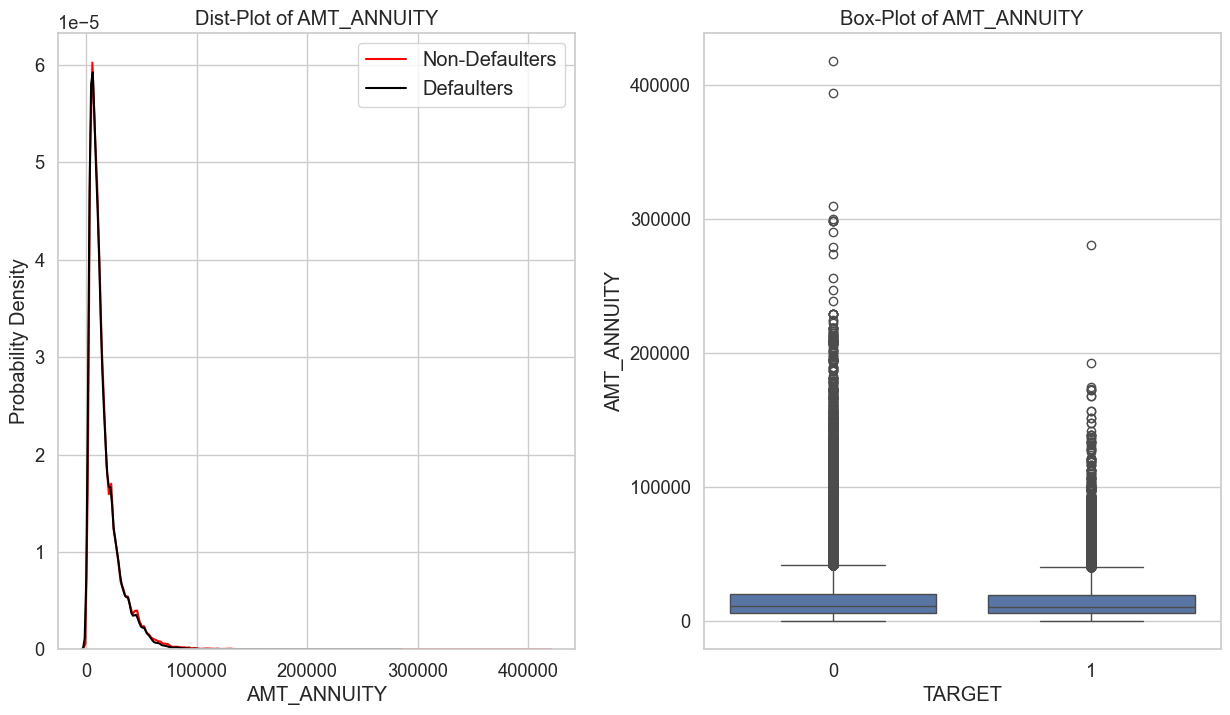

In [33]:
plot_continuous_variables(prev_merged, 'AMT_ANNUITY', plots=['distplot', 'box'], figsize=(15,8))

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối và đặc điểm của biến `AMT_ANNUITY` (khoản tiền trả góp hàng năm) giữa hai nhóm người vay (vỡ nợ và không vỡ nợ). Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li>Phân phối của `AMT_ANNUITY` trong cả hai nhóm (vỡ nợ và không vỡ nợ) có hình dạng tương tự, với sự tập trung chủ yếu ở các giá trị thấp hơn (dưới <strong>100,000</strong>), cho thấy rằng phần lớn các khoản vay có mức trả góp hàng năm tương đối thấp.</li>
    <li>Tuy nhiên, từ biểu đồ phân phối (trái), có sự trùng lặp gần như hoàn toàn giữa hai nhóm, điều này cho thấy rằng biến `AMT_ANNUITY` một mình có thể không phải là yếu tố quyết định chính để phân biệt giữa người vay vỡ nợ và không vỡ nợ.</li>
    <li>Biểu đồ hộp (phải) chỉ ra rằng có một số ngoại lệ (outliers) với các giá trị `AMT_ANNUITY` rất cao, vượt quá <strong>300,000</strong>. Những ngoại lệ này xuất hiện ở cả hai nhóm, cho thấy rằng cả người vỡ nợ và không vỡ nợ đều có khả năng vay với mức trả góp cao, mặc dù rất hiếm.</li>
    <li>Phạm vi trung vị (median) của `AMT_ANNUITY` trong cả hai nhóm là tương đối tương đồng, gợi ý rằng mức trả góp điển hình của cả hai nhóm không có sự khác biệt đáng kể.</li>
</ol>

**Kết luận:** 
- Biến `AMT_ANNUITY` chủ yếu được phân bổ ở mức thấp và có một số ngoại lệ với giá trị cao.
- Mặc dù biểu đồ chỉ ra tính tương đồng lớn giữa hai nhóm, cần phải kết hợp biến này với các biến khác để cải thiện khả năng phân loại người vay vỡ nợ và không vỡ nợ.


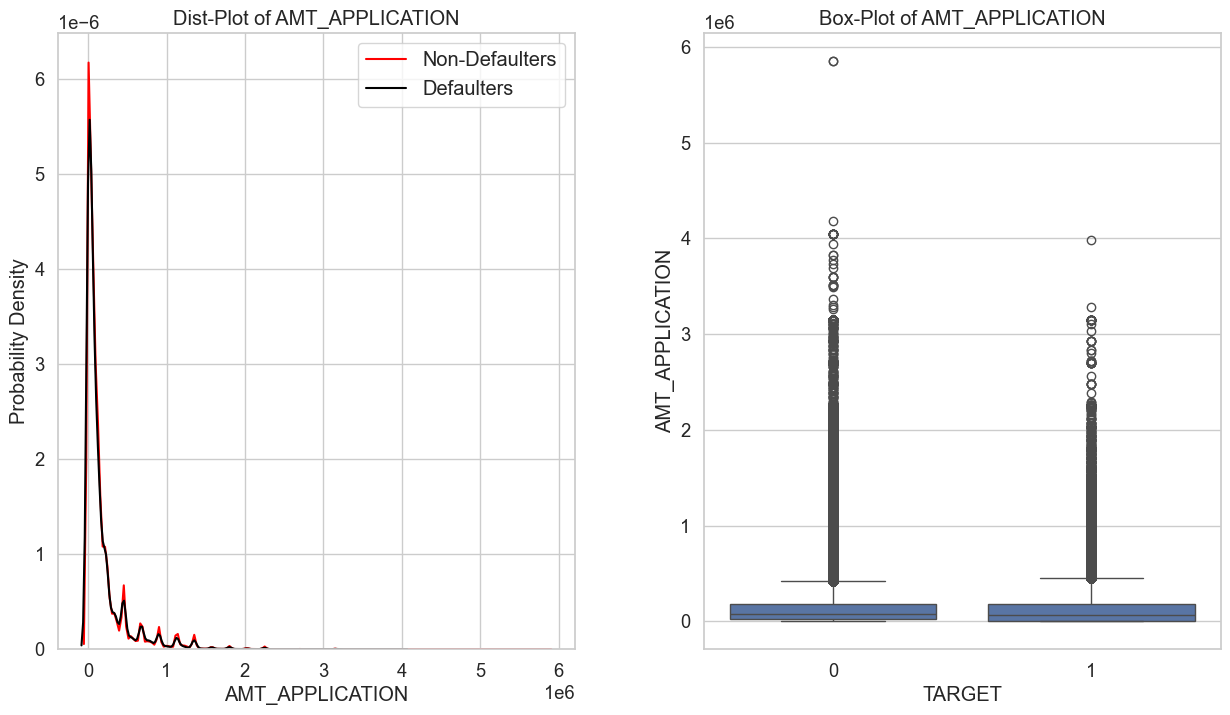

In [34]:
plot_continuous_variables(prev_merged, 'AMT_APPLICATION', plots=['distplot', 'box'], figsize=(15,8))

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối và đặc điểm của biến `AMT_APPLICATION` (số tiền ứng dụng vay) giữa hai nhóm người vay (vỡ nợ và không vỡ nợ). Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li>Phân phối của `AMT_APPLICATION` trong cả hai nhóm (vỡ nợ và không vỡ nợ) rất giống nhau, với phần lớn các khoản vay có giá trị ứng dụng thấp hơn <strong>1 triệu</strong>. Điều này cho thấy rằng giá trị ứng dụng phổ biến là tương đối nhỏ đối với cả hai nhóm.</li>
    <li>Biểu đồ phân phối (trái) cho thấy sự chồng lấp gần như hoàn toàn giữa hai nhóm, gợi ý rằng biến `AMT_APPLICATION` có thể không đóng vai trò lớn trong việc phân biệt giữa người vỡ nợ và không vỡ nợ.</li>
    <li>Biểu đồ hộp (phải) chỉ ra rằng có một số giá trị ngoại lệ (outliers) rất cao trong `AMT_APPLICATION`, vượt quá <strong>4 triệu</strong>. Những ngoại lệ này xuất hiện ở cả hai nhóm.</li>
    <li>Phần lớn giá trị `AMT_APPLICATION` tập trung ở mức thấp, với trung vị của cả hai nhóm gần nhau và không có sự khác biệt đáng kể.</li>
</ol>

**Kết luận:**
- Biến `AMT_APPLICATION` chủ yếu tập trung ở các giá trị thấp và có một số ngoại lệ với giá trị cao.
- Do sự phân phối tương đồng giữa hai nhóm, cần phải xem xét biến này trong bối cảnh các biến khác để đánh giá mức độ đóng góp của nó trong việc dự đoán khả năng vỡ nợ.


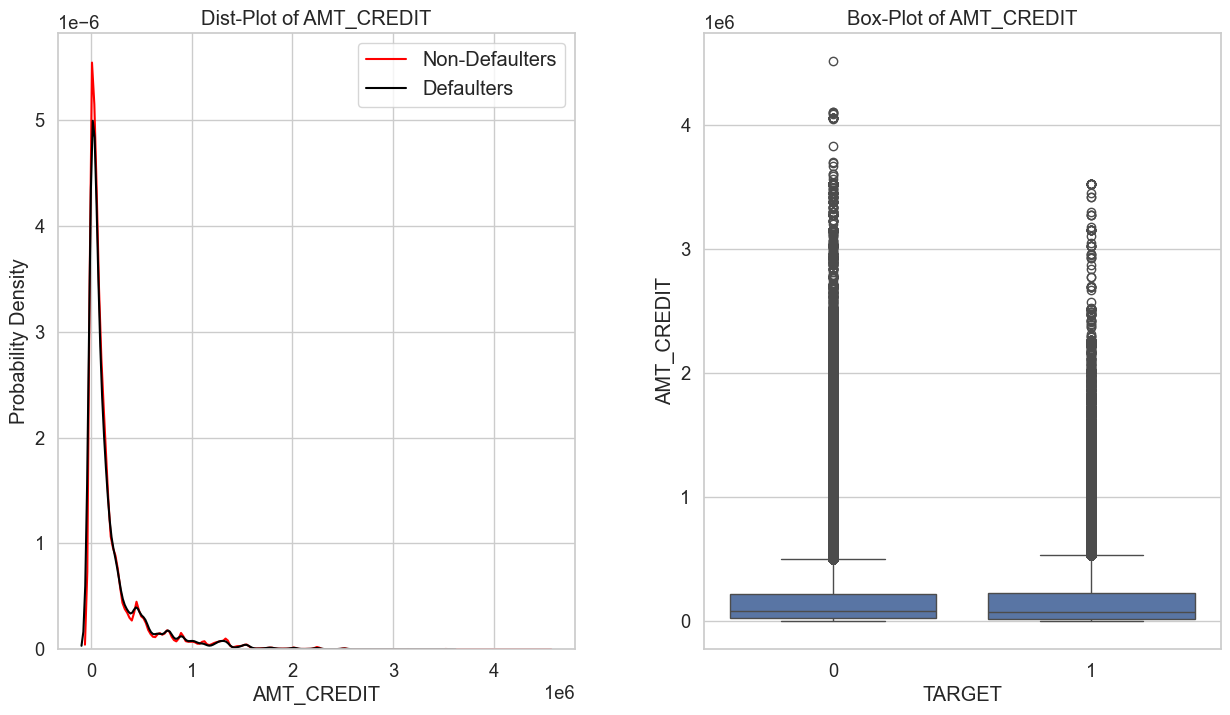

In [35]:
plot_continuous_variables(prev_merged, 'AMT_CREDIT', plots=['distplot', 'box'], figsize=(15,8))

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối và đặc điểm của biến `AMT_CREDIT` (số tiền tín dụng) giữa hai nhóm người vay (vỡ nợ và không vỡ nợ). Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li>Phân phối của `AMT_CREDIT` trong cả hai nhóm (vỡ nợ và không vỡ nợ) rất giống nhau, với phần lớn các khoản tín dụng tập trung ở mức thấp hơn <strong>1 triệu</strong>. Điều này cho thấy rằng phần lớn các khoản tín dụng được cấp với giá trị tương đối nhỏ.</li>
    <li>Biểu đồ phân phối (trái) cho thấy sự chồng lấp lớn giữa hai nhóm, điều này gợi ý rằng biến `AMT_CREDIT` không có sự khác biệt rõ ràng giữa nhóm người vỡ nợ và không vỡ nợ.</li>
    <li>Biểu đồ hộp (phải) chỉ ra rằng có một số giá trị ngoại lệ (outliers) rất cao trong `AMT_CREDIT`, vượt quá <strong>4 triệu</strong>. Những ngoại lệ này xuất hiện ở cả hai nhóm, cho thấy một số khách hàng vay tín dụng rất lớn bất kể tình trạng tín dụng.</li>
    <li>Trung vị của `AMT_CREDIT` trong cả hai nhóm là tương tự nhau, không có sự khác biệt đáng kể.</li>
</ol>

**Kết luận:**
- Biến `AMT_CREDIT` có sự phân phối tương tự và không cho thấy khác biệt rõ rệt giữa hai nhóm (vỡ nợ và không vỡ nợ).
- Giá trị ngoại lệ rất lớn trong `AMT_CREDIT` cần được xem xét cẩn thận vì có thể ảnh hưởng đến các mô hình phân tích.
- Kết hợp biến này với các yếu tố khác có thể giúp cải thiện khả năng dự đoán trong việc phân biệt nhóm vỡ nợ và không vỡ nợ.


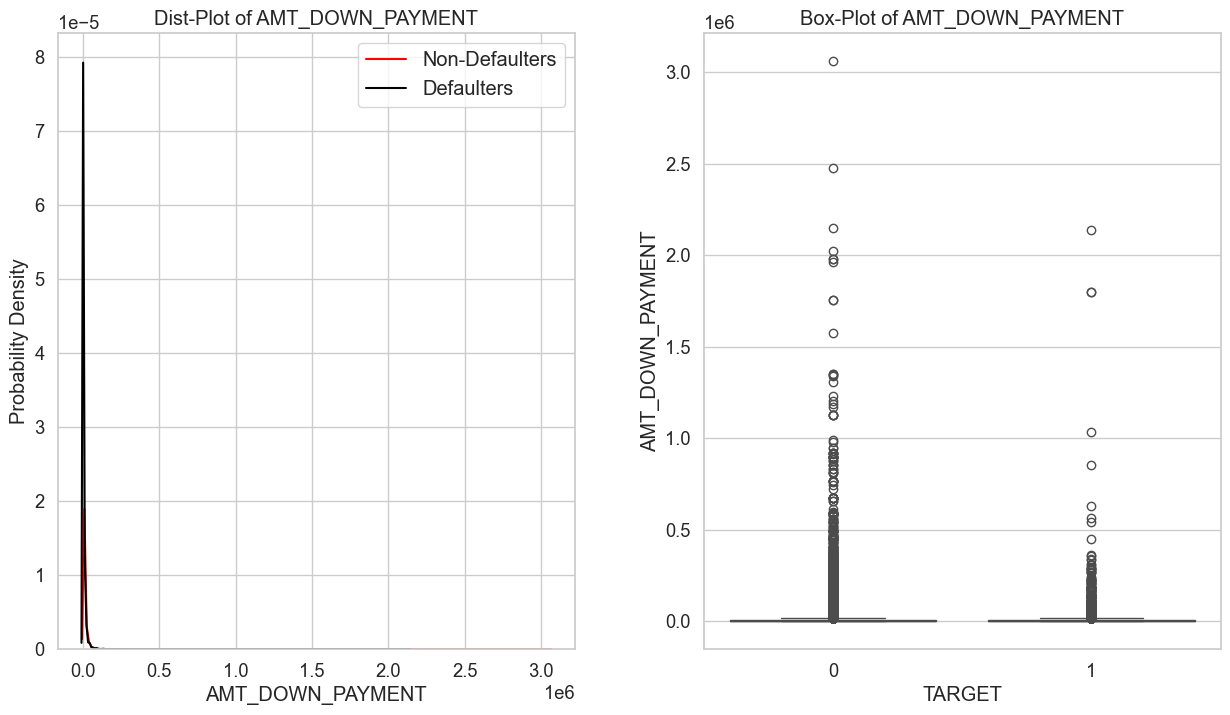

In [36]:
plot_continuous_variables(prev_merged, 'AMT_DOWN_PAYMENT', plots=['distplot', 'box'], figsize=(15,8))

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối và đặc điểm của biến `AMT_DOWN_PAYMENT` (số tiền trả trước) giữa hai nhóm người vay (vỡ nợ và không vỡ nợ). Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li>Phân phối của `AMT_DOWN_PAYMENT` trong cả hai nhóm (vỡ nợ và không vỡ nợ) cho thấy phần lớn các giá trị tập trung ở mức thấp hơn <strong>500,000</strong>, với rất ít người trả trước các khoản tiền lớn.</li>
    <li>Biểu đồ phân phối (trái) chỉ ra rằng sự khác biệt giữa hai nhóm là rất nhỏ, với đường cong gần như chồng lấp hoàn toàn, cho thấy rằng `AMT_DOWN_PAYMENT` một mình không phải là yếu tố mạnh để phân biệt giữa nhóm vỡ nợ và không vỡ nợ.</li>
    <li>Biểu đồ hộp (phải) chỉ ra sự hiện diện của nhiều giá trị ngoại lệ (outliers) ở cả hai nhóm, với các khoản tiền trả trước vượt quá <strong>2 triệu</strong>. Các giá trị ngoại lệ này xuất hiện ở cả hai nhóm.</li>
    <li>Trung vị của `AMT_DOWN_PAYMENT` trong cả hai nhóm là tương tự nhau, không có sự khác biệt đáng kể, cho thấy rằng số tiền trả trước điển hình không thay đổi nhiều giữa hai nhóm.</li>
</ol>

**Kết luận:**
- Biến `AMT_DOWN_PAYMENT` chủ yếu tập trung ở các giá trị thấp với một số giá trị ngoại lệ rất cao.
- Không có sự khác biệt đáng kể giữa nhóm vỡ nợ và không vỡ nợ trong phân phối của biến này.
- Cần xem xét biến này cùng với các biến khác để xác định mối quan hệ có ý nghĩa với rủi ro vỡ nợ.


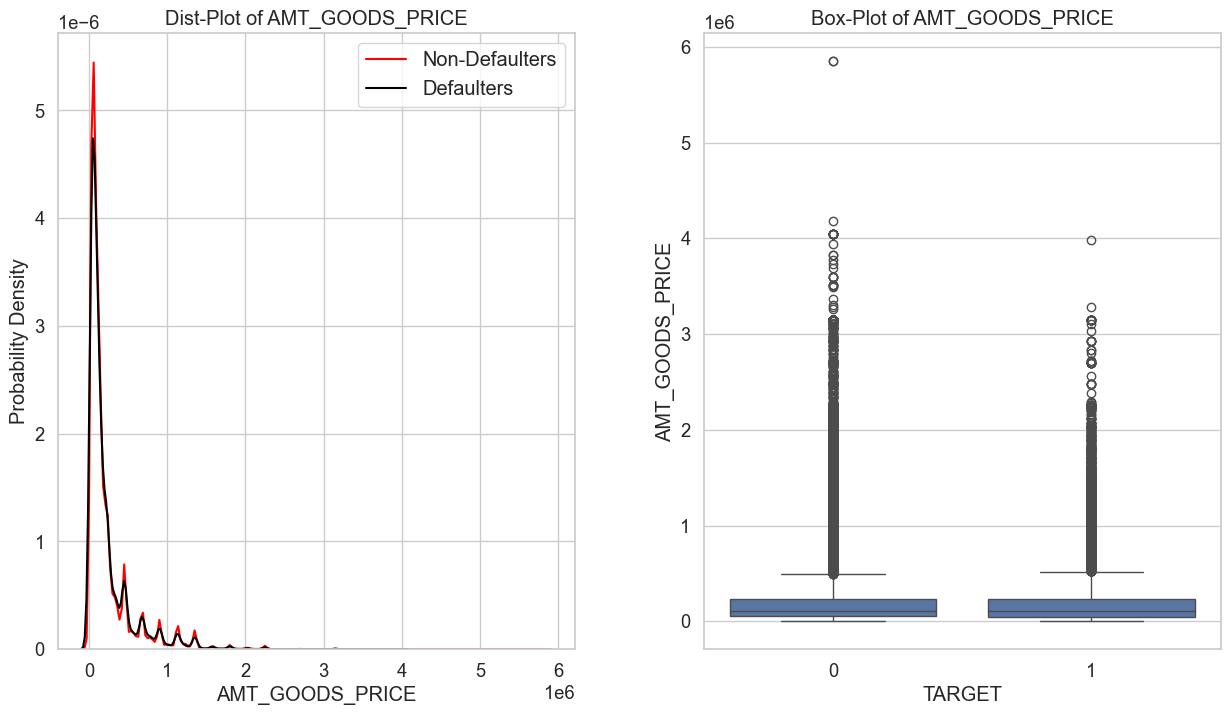

In [37]:
plot_continuous_variables(prev_merged, 'AMT_GOODS_PRICE', plots=['distplot', 'box'], figsize=(15,8))

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối và đặc điểm của biến `AMT_GOODS_PRICE` (giá trị hàng hóa được vay) giữa hai nhóm người vay (vỡ nợ và không vỡ nợ). Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li>Phân phối của `AMT_GOODS_PRICE` trong cả hai nhóm (vỡ nợ và không vỡ nợ) rất giống nhau, với phần lớn các giá trị tập trung ở mức thấp hơn <strong>1 triệu</strong>. Điều này cho thấy rằng phần lớn các khoản vay liên quan đến các hàng hóa có giá trị vừa phải.</li>
    <li>Biểu đồ phân phối (trái) chỉ ra rằng sự chồng lấp giữa hai nhóm là rất lớn, điều này gợi ý rằng `AMT_GOODS_PRICE` không có sự khác biệt rõ ràng giữa người vỡ nợ và không vỡ nợ.</li>
    <li>Biểu đồ hộp (phải) cho thấy sự hiện diện của nhiều giá trị ngoại lệ (outliers) ở cả hai nhóm, với các giá trị vượt quá <strong>4 triệu</strong>. Những ngoại lệ này xuất hiện ở cả hai nhóm, cho thấy một số khoản vay liên quan đến hàng hóa có giá trị rất cao.</li>
    <li>Trung vị của `AMT_GOODS_PRICE` trong cả hai nhóm là tương tự nhau, không có sự khác biệt đáng kể, gợi ý rằng giá trị hàng hóa trung bình của người vỡ nợ và không vỡ nợ là giống nhau.</li>
</ol>

**Kết luận:**
- Biến `AMT_GOODS_PRICE` chủ yếu tập trung ở các giá trị vừa phải và có một số ngoại lệ với giá trị cao.
- Không có sự khác biệt đáng kể giữa hai nhóm (vỡ nợ và không vỡ nợ) về phân phối của biến này.
- Để tăng cường khả năng phân biệt, biến này cần được sử dụng cùng với các biến khác trong mô hình dự đoán.


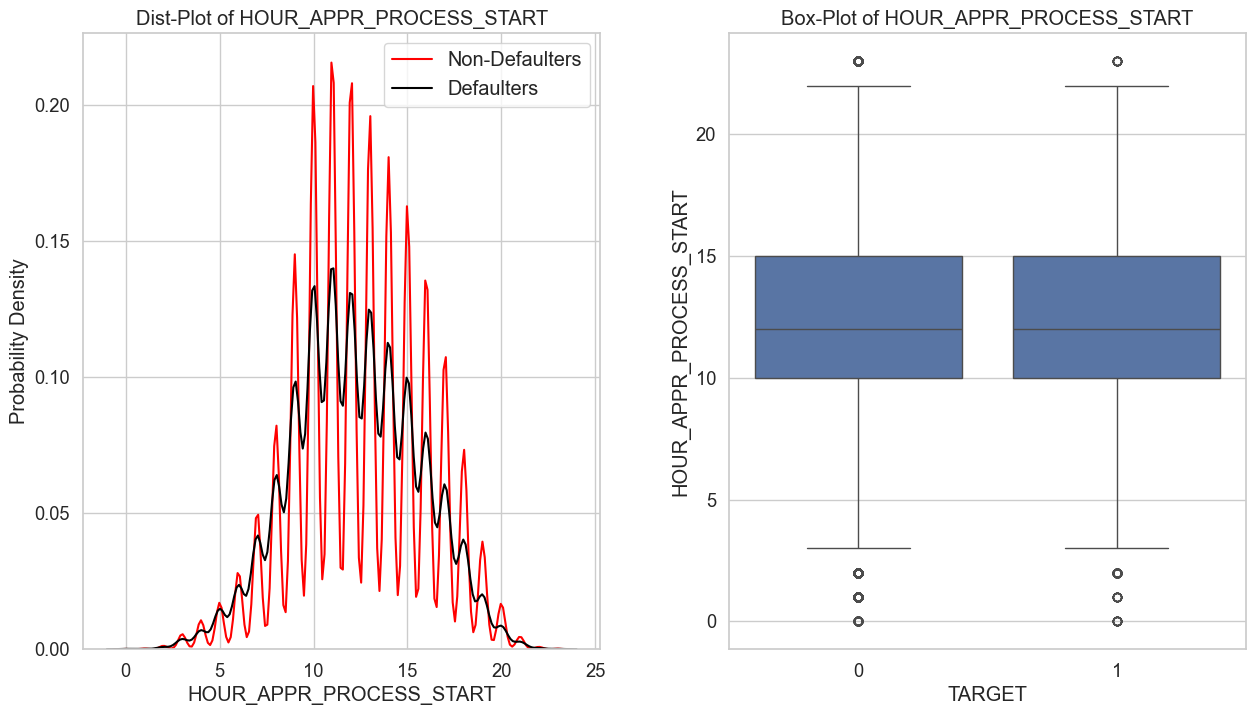

In [38]:
plot_continuous_variables(prev_merged, 'HOUR_APPR_PROCESS_START', plots=['distplot', 'box'], figsize=(15,8))

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối và đặc điểm của biến `HOUR_APPR_PROCESS_START` (giờ bắt đầu xử lý đơn vay) giữa hai nhóm người vay (vỡ nợ và không vỡ nợ). Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li>Phân phối của `HOUR_APPR_PROCESS_START` trong cả hai nhóm (vỡ nợ và không vỡ nợ) tương tự nhau, với phần lớn các đơn vay được xử lý trong khoảng thời gian từ <strong>9 giờ sáng đến 6 giờ chiều</strong>. Đây là khoảng thời gian làm việc thông thường.</li>
    <li>Biểu đồ phân phối (trái) cho thấy rằng sự chồng lấp giữa hai nhóm là rất lớn, điều này gợi ý rằng `HOUR_APPR_PROCESS_START` không phải là yếu tố quyết định để phân biệt giữa người vỡ nợ và không vỡ nợ.</li>
    <li>Biểu đồ hộp (phải) chỉ ra rằng trung vị của `HOUR_APPR_PROCESS_START` trong cả hai nhóm là tương tự nhau, dao động quanh khoảng <strong>10 đến 12 giờ trưa</strong>, không có sự khác biệt đáng kể.</li>
    <li>Các giá trị ngoại lệ (outliers) xuất hiện ở cả hai nhóm, với một số đơn vay được xử lý vào giờ rất sớm (khoảng <strong>0 - 5 giờ sáng</strong>), điều này có thể phản ánh các trường hợp đặc biệt hoặc do tính chất hoạt động 24/7 của một số tổ chức tài chính.</li>
</ol>

**Kết luận:**
- Biến `HOUR_APPR_PROCESS_START` chủ yếu tập trung vào giờ làm việc hành chính thông thường và không có sự khác biệt rõ ràng giữa hai nhóm.
- Các giá trị ngoại lệ (xử lý đơn vay vào giờ bất thường) cần được xem xét trong bối cảnh các yếu tố khác để đánh giá ý nghĩa của chúng trong mô hình dự đoán.


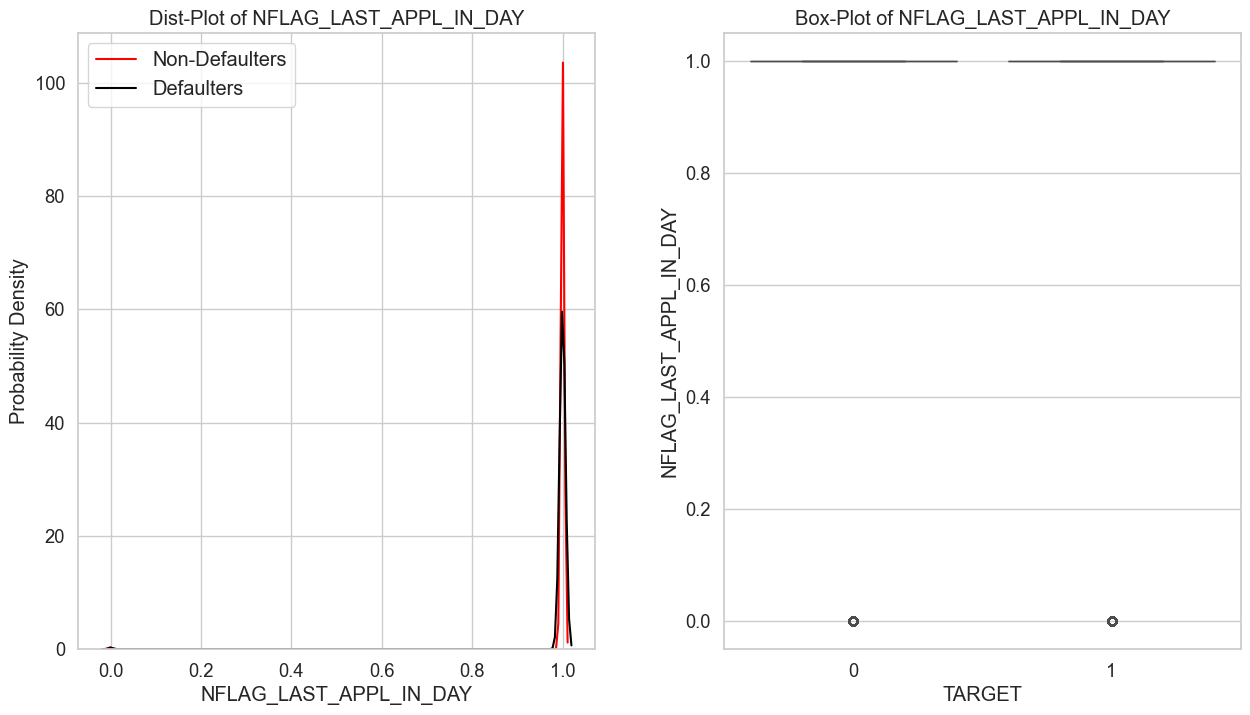

In [39]:
plot_continuous_variables(prev_merged, 'NFLAG_LAST_APPL_IN_DAY', plots=['distplot', 'box'], figsize=(15,8))

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối và đặc điểm của biến `NFLAG_LAST_APPL_IN_DAY` (cờ chỉ định nếu đây là ứng dụng cuối cùng trong ngày) giữa hai nhóm người vay (vỡ nợ và không vỡ nợ). Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li>Phân phối của `NFLAG_LAST_APPL_IN_DAY` chỉ có hai giá trị khả thi: <strong>0</strong> và <strong>1</strong>, do đây là một biến nhị phân. Phần lớn các đơn vay thuộc giá trị <strong>1</strong>, nghĩa là ứng dụng cuối cùng trong ngày.</li>
    <li>Biểu đồ phân phối (trái) cho thấy sự chồng lấp hoàn toàn giữa hai nhóm (vỡ nợ và không vỡ nợ). Điều này gợi ý rằng biến này không có khả năng phân biệt giữa hai nhóm người vay.</li>
    <li>Biểu đồ hộp (phải) chỉ ra rằng không có sự khác biệt nào về phân phối giữa hai nhóm. Cả hai nhóm đều có các giá trị chủ yếu nằm ở mức <strong>1</strong>.</li>
    <li>Rất ít ngoại lệ (outliers) xuất hiện trong dữ liệu, với một số giá trị <strong>0</strong>, cho thấy rằng đây không phải là trường hợp phổ biến.</li>
</ol>

**Kết luận:**
- Biến `NFLAG_LAST_APPL_IN_DAY` không thể hiện sự khác biệt đáng kể giữa nhóm vỡ nợ và không vỡ nợ.
- Do tính chất nhị phân và phân phối tập trung, biến này có thể không đóng vai trò quan trọng trong việc dự đoán khả năng vỡ nợ.
- Cần xem xét kết hợp với các biến khác để đánh giá thêm giá trị của biến này trong phân tích tín dụng.


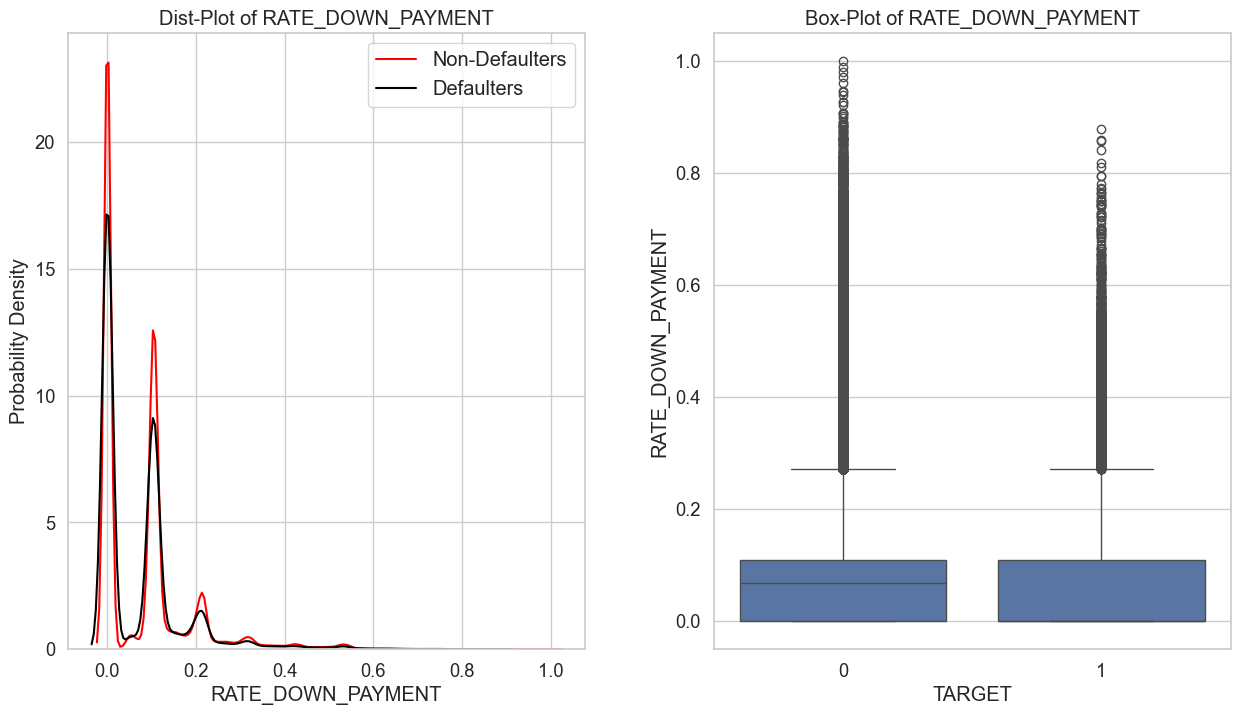

In [40]:
plot_continuous_variables(prev_merged, 'RATE_DOWN_PAYMENT', plots=['distplot', 'box'], figsize=(15,8))

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối và đặc điểm của biến `RATE_DOWN_PAYMENT` (tỷ lệ trả trước) giữa hai nhóm người vay (vỡ nợ và không vỡ nợ). Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li>Phân phối của `RATE_DOWN_PAYMENT` trong cả hai nhóm (vỡ nợ và không vỡ nợ) tương đối giống nhau, với phần lớn các giá trị tập trung ở mức rất thấp (<strong>0.2</strong>), phản ánh rằng đa số khách hàng chỉ trả trước một tỷ lệ nhỏ của khoản vay.</li>
    <li>Biểu đồ phân phối (trái) chỉ ra rằng có một số khác biệt nhỏ ở các đỉnh phụ (peaks), nhưng sự khác biệt này không đáng kể và hai nhóm vẫn chồng lấp phần lớn.</li>
    <li>Biểu đồ hộp (phải) cho thấy rằng trung vị của `RATE_DOWN_PAYMENT` trong cả hai nhóm là tương tự, với phạm vi giá trị chủ yếu nằm dưới <strong>0.5</strong>. Một số giá trị ngoại lệ (outliers) xuất hiện với tỷ lệ trả trước cao hơn, vượt mức <strong>0.7</strong>.</li>
    <li>Phân phối cho thấy rằng tỷ lệ trả trước cao hơn (> <strong>0.5</strong>) là rất hiếm ở cả hai nhóm, và các giá trị này không thể hiện sự khác biệt rõ ràng giữa người vỡ nợ và không vỡ nợ.</li>
</ol>

**Kết luận:**
- Biến `RATE_DOWN_PAYMENT` chủ yếu tập trung ở các giá trị thấp, với một số ngoại lệ có tỷ lệ trả trước cao hơn.
- Không có sự khác biệt đáng kể giữa hai nhóm (vỡ nợ và không vỡ nợ) trong phân phối của biến này.
- Cần sử dụng biến này cùng với các yếu tố khác để tăng khả năng phân tích và dự đoán.


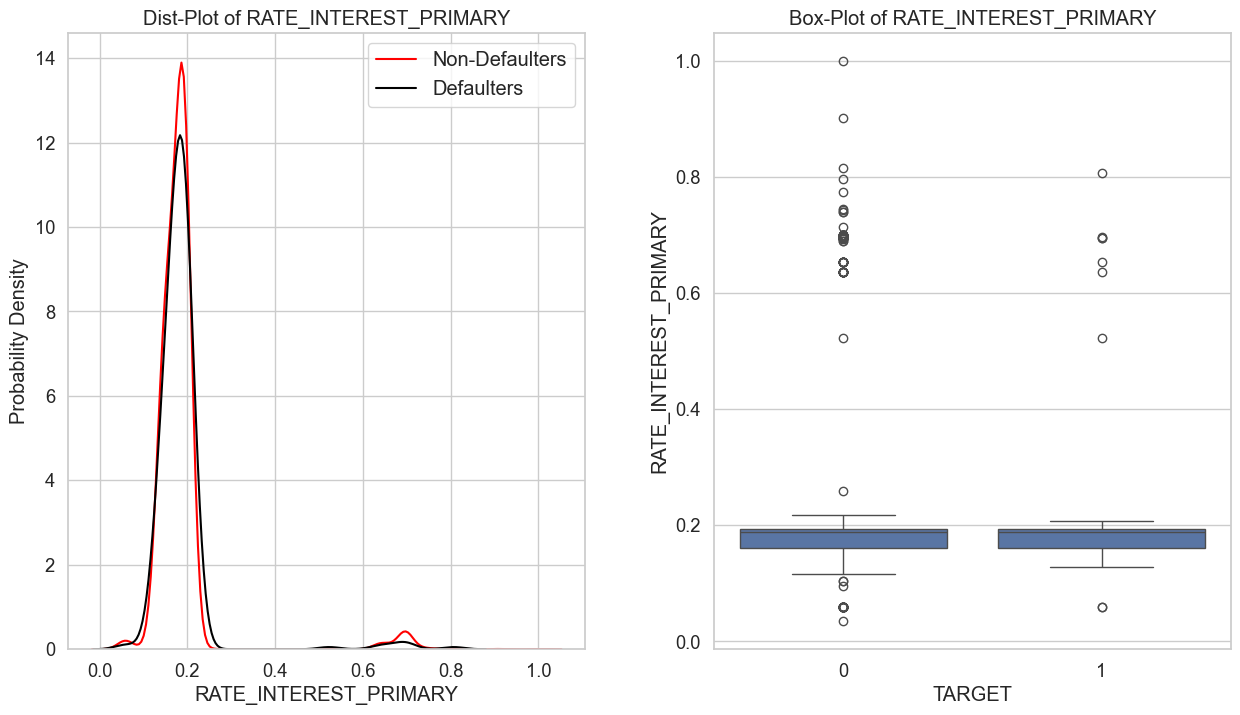

In [41]:
plot_continuous_variables(prev_merged, 'RATE_INTEREST_PRIMARY', plots=['distplot', 'box'], figsize=(15,8))

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối và đặc điểm của biến `RATE_INTEREST_PRIMARY` (lãi suất chính) giữa hai nhóm người vay (vỡ nợ và không vỡ nợ). Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li>Phân phối của `RATE_INTEREST_PRIMARY` trong cả hai nhóm (vỡ nợ và không vỡ nợ) rất giống nhau, với phần lớn các giá trị tập trung quanh <strong>0.2</strong>, phản ánh rằng đây là mức lãi suất phổ biến.</li>
    <li>Biểu đồ phân phối (trái) chỉ ra rằng có một số đỉnh phụ (peaks) nhỏ ở các mức cao hơn, nhưng phần lớn dữ liệu tập trung ở mức thấp, và hai nhóm chồng lấp nhau phần lớn.</li>
    <li>Biểu đồ hộp (phải) cho thấy rằng trung vị của `RATE_INTEREST_PRIMARY` trong cả hai nhóm là tương tự, với phạm vi giá trị chủ yếu nằm dưới <strong>0.4</strong>. Một số giá trị ngoại lệ (outliers) xuất hiện với lãi suất cao hơn, vượt mức <strong>0.8</strong>.</li>
    <li>Phân phối của các giá trị ngoại lệ là khá hiếm, và những giá trị này không thể hiện sự khác biệt rõ ràng giữa hai nhóm (vỡ nợ và không vỡ nợ).</li>
</ol>

**Kết luận:**
- Biến `RATE_INTEREST_PRIMARY` có phân phối tập trung ở mức thấp, với một số ngoại lệ ở mức lãi suất cao hơn.
- Không có sự khác biệt đáng kể giữa hai nhóm (vỡ nợ và không vỡ nợ) trong phân phối của biến này.
- Biến này nên được kết hợp với các yếu tố khác để xác định tác động của lãi suất lên rủi ro tín dụng.


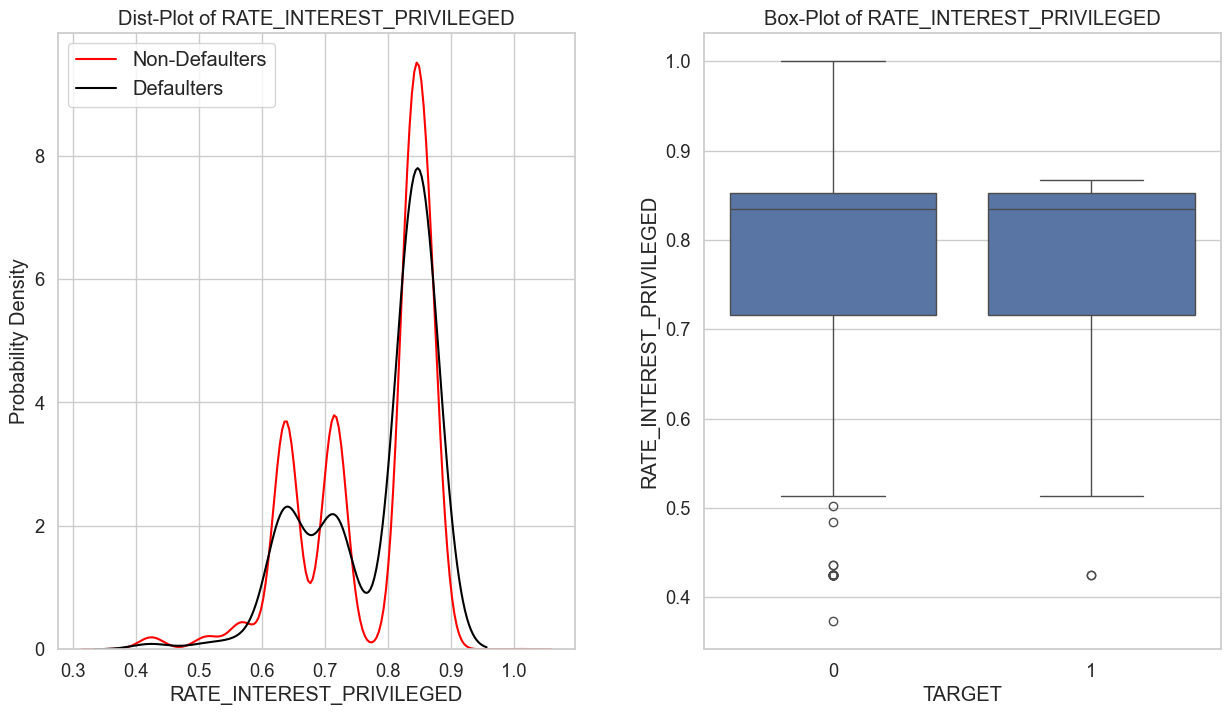

In [42]:
plot_continuous_variables(prev_merged, 'RATE_INTEREST_PRIVILEGED', plots=['distplot', 'box'], figsize=(15,8))

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối và đặc điểm của biến `RATE_INTEREST_PRIVILEGED` (lãi suất ưu đãi) giữa hai nhóm người vay (vỡ nợ và không vỡ nợ). Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li>Phân phối của `RATE_INTEREST_PRIVILEGED` trong cả hai nhóm (vỡ nợ và không vỡ nợ) khá tương đồng, với phần lớn các giá trị tập trung quanh mức <strong>0.8</strong>. Đây có vẻ là mức lãi suất ưu đãi phổ biến nhất.</li>
    <li>Biểu đồ phân phối (trái) cho thấy có một số đỉnh phụ (peaks) ở các mức thấp hơn như <strong>0.7</strong> và <strong>0.6</strong>. Tuy nhiên, hai nhóm có sự chồng lấp lớn, cho thấy rằng biến này không phải là yếu tố phân biệt rõ rệt giữa nhóm vỡ nợ và không vỡ nợ.</li>
    <li>Biểu đồ hộp (phải) cho thấy rằng trung vị của `RATE_INTEREST_PRIVILEGED` trong cả hai nhóm là tương tự, nằm ở khoảng <strong>0.8</strong>, và phạm vi dữ liệu chính yếu nằm giữa <strong>0.7</strong> và <strong>0.9</strong>.</li>
    <li>Một số giá trị ngoại lệ (outliers) thấp hơn xuất hiện ở cả hai nhóm, với các lãi suất dưới <strong>0.5</strong>. Những giá trị này có thể phản ánh các trường hợp vay đặc biệt.</li>
</ol>

**Kết luận:**
- Biến `RATE_INTEREST_PRIVILEGED` có phân phối tương tự giữa hai nhóm, với phần lớn giá trị tập trung quanh mức lãi suất phổ biến <strong>0.8</strong>.
- Các giá trị ngoại lệ thấp hơn (<strong>0.5</strong>) cần được phân tích thêm để xác định tính chất hoặc ý nghĩa.
- Cần xem xét biến này cùng với các yếu tố khác để đánh giá đầy đủ tác động của lãi suất ưu đãi lên rủi ro tín dụng.


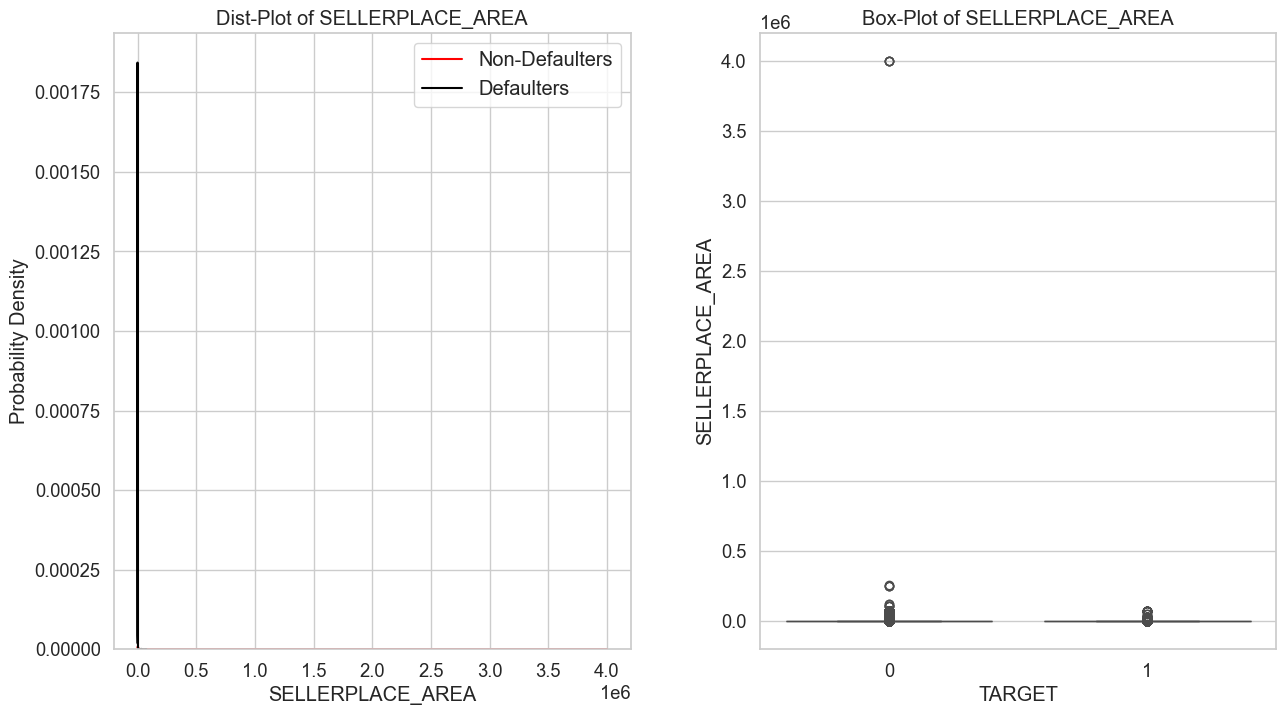

In [43]:
plot_continuous_variables(prev_merged, 'SELLERPLACE_AREA', plots=['distplot', 'box'], figsize=(15,8))

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối và đặc điểm của biến `SELLERPLACE_AREA` (diện tích khu vực bán hàng) giữa hai nhóm người vay (vỡ nợ và không vỡ nợ). Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li>Phân phối của `SELLERPLACE_AREA` cho thấy rằng hầu hết các giá trị tập trung ở mức rất nhỏ, gần <strong>0</strong>, cho cả hai nhóm (vỡ nợ và không vỡ nợ).</li>
    <li>Biểu đồ phân phối (trái) chỉ ra rằng hai nhóm chồng lấp hoàn toàn, và không có sự khác biệt rõ rệt trong phân phối giữa người vỡ nợ và không vỡ nợ.</li>
    <li>Biểu đồ hộp (phải) chỉ ra rằng phần lớn dữ liệu nằm trong một phạm vi rất hẹp, với một số giá trị ngoại lệ (outliers) vượt quá <strong>4,000,000</strong>. Những giá trị này là hiếm và xuất hiện ở cả hai nhóm.</li>
    <li>Trung vị và khoảng tứ phân vị (IQR) của `SELLERPLACE_AREA` tương tự nhau ở cả hai nhóm, cho thấy rằng biến này không có tác động đáng kể trong việc phân biệt giữa người vỡ nợ và không vỡ nợ.</li>
</ol>

**Kết luận:**
- Biến `SELLERPLACE_AREA` chủ yếu tập trung ở mức thấp, với một số giá trị ngoại lệ rất cao.
- Không có sự khác biệt đáng kể giữa hai nhóm (vỡ nợ và không vỡ nợ) trong phân phối của biến này.
- Do sự tập trung dữ liệu ở mức rất nhỏ, biến này có thể không mang lại giá trị dự đoán cao trừ khi được phân tích cùng với các yếu tố khác.


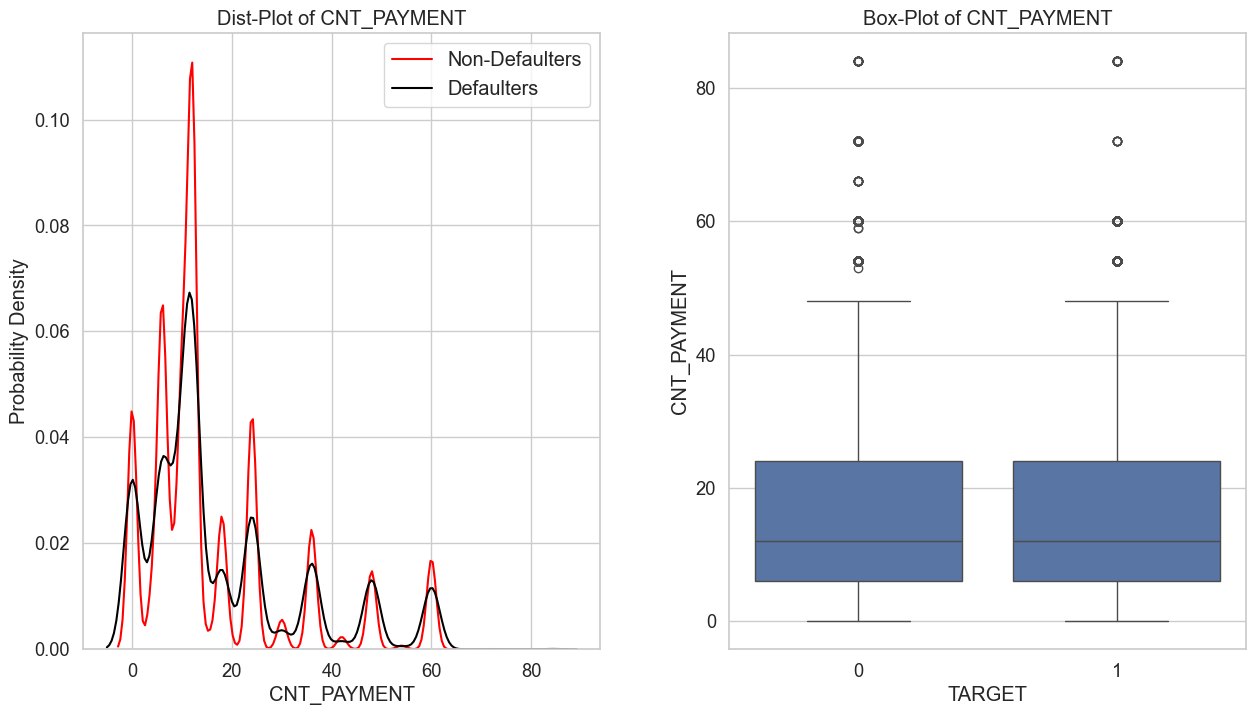

In [44]:
plot_continuous_variables(prev_merged, 'CNT_PAYMENT', plots=['distplot', 'box'], figsize=(15,8))

##### **Quan sát và Kết luận:**

Biểu đồ phía trên cho thấy phân phối và đặc điểm của biến `CNT_PAYMENT` (số lần thanh toán) giữa hai nhóm người vay (vỡ nợ và không vỡ nợ). Những nhận định sau có thể được rút ra từ biểu đồ này:

<ol>
    <li>Phân phối của `CNT_PAYMENT` trong cả hai nhóm (vỡ nợ và không vỡ nợ) rất giống nhau, với phần lớn các giá trị tập trung trong khoảng <strong>10 đến 30 lần thanh toán</strong>. Điều này phản ánh rằng đa số khách hàng có kế hoạch thanh toán trong khoảng trung bình.</li>
    <li>Biểu đồ phân phối (trái) chỉ ra rằng có một số đỉnh phụ (peaks) ở các mức lớn hơn, như <strong>60</strong>, nhưng hai nhóm có sự chồng lấp lớn, không thể hiện sự khác biệt rõ rệt.</li>
    <li>Biểu đồ hộp (phải) cho thấy rằng trung vị của `CNT_PAYMENT` trong cả hai nhóm là tương tự, nằm trong khoảng <strong>20 lần thanh toán</strong>, với khoảng giá trị chính yếu nằm dưới <strong>40 lần thanh toán</strong>.</li>
    <li>Một số giá trị ngoại lệ (outliers) xuất hiện ở cả hai nhóm với số lần thanh toán vượt quá <strong>60</strong>, nhưng những giá trị này là hiếm.</li>
</ol>

**Kết luận:**
- Biến `CNT_PAYMENT` chủ yếu tập trung ở mức trung bình (10-30 lần thanh toán) và không có sự khác biệt đáng kể giữa hai nhóm (vỡ nợ và không vỡ nợ).
- Các giá trị ngoại lệ (với số lần thanh toán rất lớn) cần được phân tích thêm để xác định tính chất hoặc ý nghĩa trong các trường hợp vay cụ thể.
- Biến này có thể không phải là yếu tố mạnh để phân biệt rủi ro tín dụng nếu được sử dụng độc lập, nhưng có thể hữu ích khi kết hợp với các biến khác.
